
# How to check all possible target binding sites against off-target binding sites in whole transcriptome
We have a target mRNA that we want to bind with RNA binding proteins. To design these pumby proteins we need to select binding sites on our target mRNA which are very unique, i.e. ideally dont occure elsewhere the transcriptome.  Or more general: We have a target sequence and we want to find a subsequence of specified length which is as specific to this target as possible i.e. has the least interactions with dataset of reference sequences. 

**This notebook is focused on testing and building up step by step the basic algorithm using random sequences.** To see the algorithm applied to real sequences see the "main" notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import pandas as pd
from time import time
import warnings



 <br>

# Search off-target binding-sites on single transcript 
= global sequence comparison of query with a reference sequence
- as we are searching for binding sites in the transcriptome, we'd ideally find as few as possible to avoid unwanted side-effects.
- As the binding sites are usually shorter then the persistence length of the polymers, a global sequence alignment search should suffice (we dont need BLAST)

In [2]:

@njit
def sc_jit(seq, ref):
    '''A fast sequence comparison of a short query sequence (seq) against a larger reference (ref).
    Returns the number of matches for every position the sort sequence could bind to the larger one. Consideres only full overlap binding, i.e. no overhangs '''

    n = len(ref) - len(seq) + 1
    if n<1: print("sc_jit: wrong argument order")
    cv = np.zeros(n, dtype=np.int8) 
    for i in range(n):
        WEIGHT = 0
        for j in range(len(seq)):
            if ref[i + j] == seq[j]:
                WEIGHT += 1
        cv[i] = WEIGHT
    return cv
    
def random_seq(size):
    return ''.join(np.array(["A", "C", "G", "T"])[np.random.randint(low = 0, high = 4, size = size)])

sc_jit(random_seq(10), random_seq(10));    # call it once so that numba compiles it

%timeit sc_jit(random_seq(10).encode(), random_seq(10).encode())

%timeit sc_jit(random_seq(10), random_seq(10))


24.2 μs ± 220 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
30.3 μs ± 561 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [3]:
query = pd.Series({"SEQ_NAME": "rand_candidate",     "SEQUENCE": random_seq(size = 12)})       # the query sequence i.e. a candidate binding sequence for the target 
ref   = pd.Series({"SEQ_NAME": "rand_transcript_#0", "SEQUENCE": random_seq(size = 10**3)})    # The reference to check against, i.e. a transcript from the transcriptome in this example

{'mismatch_eq_0': np.int64(0),
 'mismatch_eq_1': np.int64(0),
 'mismatch_eq_2': np.int64(0),
 'boltzmann factor': np.float64(0.02836335372466799)}

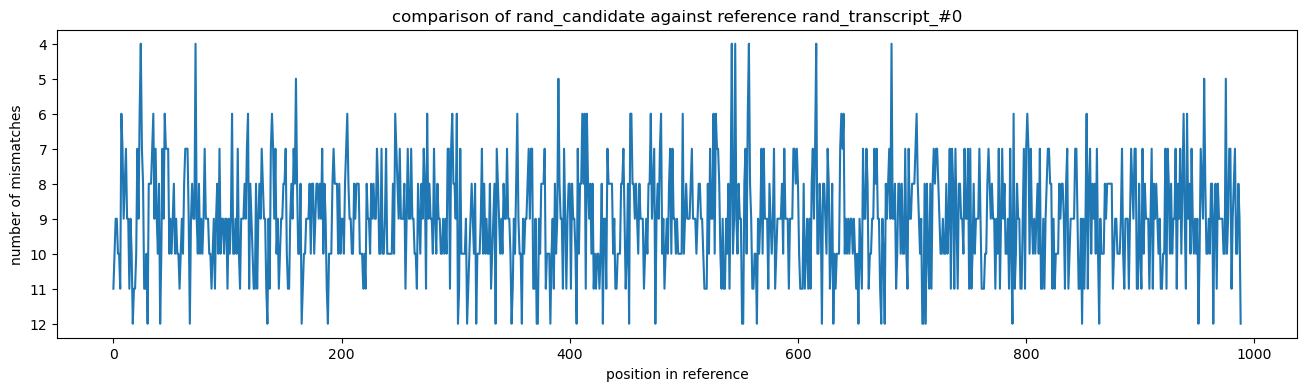

In [4]:
mm = len(query.SEQUENCE)-sc_jit(query.SEQUENCE.encode(), ref.SEQUENCE.encode()) # mm = number of mismatches per position; encoding strings into bytes is faster for some reason

sc_results = {}                                              # summarize the possible binding sites of the query sequence against one reference sequence i.e. a transcript from the transcriptome
sc_results["mismatch_eq_0"] = (mm==0).sum()                  # number of idential matches
sc_results["mismatch_eq_1"] = (mm==1).sum()                  # number of matches with 1 mismatch
sc_results["mismatch_eq_2"] = (mm==2).sum()                  # number of matches with 2 mistmatches
sc_results["boltzmann factor"] = np.sum(np.exp(-1.5*mm))     # a very basic prediction of how likely the query sequence would bind to the reference. The wildtype pumilios have ~ 18 hydrogen bonds for 8nt i.e. 2.25 hydgrogen bonds = 2.25kT per bp, however the pumby appears to only have ~2 H-bonds per bp, and the binding statistics suggest closer to 1kT -> lets go with 1.5 for now, in the future a more accurate model might be implemented. Currently the boltzmann_factor for a perfect match is 1, if therefore this predicted boltzmann_factor is smaller than 1 than it is more likly to bind to the specific RNA, while if it is larger than one it is more likely to bind to the background transcriptom 
        
plt.figure(figsize=(16, 4))
plt.plot(mm)
plt.gca().invert_yaxis()
plt.ylabel("number of mismatches")
plt.xlabel(f"position in reference")
plt.title(f"comparison of {query.SEQ_NAME} against reference {ref.SEQ_NAME}")
sc_results

<br>  

# Search for off-target binding-sites in a dataset of transcripts
= compare a query to a dataset of reference sequences

In [5]:
binding_site_len = 10  # length of the binding sites (8-12 for pumby)
plot = True
use_weights = True


# generate input sequences
reference_dataset = pd.DataFrame([{"SEQ_NAME": f"random_transcript_#{i:04d}", "SEQUENCE": random_seq(size = 10**3), "WEIGHT": np.random.poisson(5)/5} for i in range(10000)])  # The reference to check against, i.e. a transcript from the transcriptome in this example
target_sequence   = pd.Series(    {"SEQ_NAME": "random_target",           "SEQUENCE": random_seq(size = 800),   "WEIGHT": 1})                                                  # The sequence from which we want ot find the best/unique binding site

# generate dataset of all possible binding sequences
query_dataset = pd.DataFrame([{"SEQ_NAME": target_sequence.SEQ_NAME + f"_{k}:{k+binding_site_len}", "SEQUENCE":target_sequence.SEQUENCE[k:k+binding_site_len],  "WEIGHT": target_sequence.WEIGHT} for k in range(len(target_sequence.SEQUENCE)-binding_site_len)] )
query = query_dataset.sample().iloc[0]  # pick a random binding site candidate for this test
query

SEQ_NAME    random_target_716:726
SEQUENCE               TCAGTTATTA
WEIGHT                          1
Name: 716, dtype: object

In [6]:
#-------------------------------------------------#
#              input arguments check              #
#-------------------------------------------------#


if not ("SEQ_NAME" in reference_dataset.columns and "SEQUENCE" in reference_dataset.columns):
    raise ValueError('reference_dataset does not contain required columns: SEQ_NAME, SEQUENCE')

if type(query) == pd.Series:  pass # everything is fine
elif type(query) == str:           # convert to pandas series
    warnings.warn("Warning, deprecated input type for query: string. Please use pandas.Series!")
    query = pd.Series({"SEQ_NAME": "unnamed", "SEQUENCE": query})
elif type(query) == pd.DataFrame and len(query) == 1:
    query = query.iloc[0]
else: raise ValueError("unsupported type for 'query', use pandas.Series")

if type(reference_dataset) == pd.DataFrame: pass # everything is fine
else: raise ValueError("unsopported type for 'reference_dataset', use pandas.DataFrame")

nts = set(reference_dataset.SEQUENCE.sample(100).sum()) | set(target_sequence.SEQUENCE)
if len(nts) != 4: # check how many nucleotides are used
    warnings.warn(f"Warning, expected 4 types of nucleoties in the input, found (at least) {len(nts)}")

joined_DF = pd.concat([pd.DataFrame([target_sequence]), reference_dataset], axis = 0)  # add the target itself to the dataset to check against

if use_weights:  # check if the input data is okay to use weighted evalutation
    if "WEIGHT" in joined_DF.columns:
        invalid = joined_DF.WEIGHT.isin([np.inf, -np.inf, np.nan])
        if invalid.any():  
            warnings.warn(f"{invalid.sum()} entries with nan or inf WEIGHT. The script might not behave as intended.")
    else: 
        print("No WEIGHT column found, switching 'use_weights = False'")
        use_weights = False



In [7]:
#-------------------------------------------------#
#  Search for binding sites in reference dataset  #
#-------------------------------------------------#
 
detailed_search_results = pd.DataFrame()                     # initialize a dataset to store the results of comparing query sequence with every reference i.e. every transcript in the transcriptome

### check type and encode if not already done (makes it run faster, dunno why)
if type(query.SEQUENCE) == str:  q_seq = query.SEQUENCE.encode()
elif type(query.SEQUENCE) == bytes: q_seq = query.SEQUENCE
else: raise ValueError(f"unsuppported type for query sequence: {type(query.SEQUENCE)}")

for i, ref in joined_DF.iterrows():                          # iterate over all reference sequences. and the target itself as control 

    ### check type and encode if not already done (makes it run faster, dunno why)
    if type(ref.SEQUENCE) == str:  r_seq = ref.SEQUENCE.encode()
    elif type(ref.SEQUENCE) == bytes: r_seq = ref.SEQUENCE
    else: raise ValueError(f"unsuppported type for query sequence: {type(ref.SEQUENCE)}")

    mm = len(q_seq)-sc_jit(q_seq, r_seq)                      # number of mismatches per position # utf8 encoding of strings to integers speeds up the comparison for some reason
    sc_row = {"SEQ_NAME": ref.SEQ_NAME}                       # summarize the possible binding sites of the query sequence against one reference sequence (here a transcript)
    if use_weights: sc_row |= {"WEIGHT":ref.WEIGHT}      
    sc_row["identical match"] = (mm==0).sum()                 # number of idential matches
    sc_row["1nt mismatch"]    = (mm==1).sum()                 # number of sites with 1 mismatch
    sc_row["2nt mismatch"]    = (mm==2).sum()                 # number of sites with 2 mistmatches
    sc_row["boltzmann factor"] = np.sum(np.exp(-1.5*mm))      # a very basic prediction of how likely the query sequence would bind to the reference. The wildtype pumilios have ~ 18 hydrogen bonds for 8nt i.e. 2.25 hydgrogen bonds = 2.25kT per bp, however the pumby appears to only have ~2 H-bonds per bp, and the binding statistics suggest closer to 1kT -> lets go with 1.5 for now, in the future a more accurate model might be implemented. Currently the boltzmann_factor for a perfect match is 1, if therefore this predicted boltzmann_factor is smaller than 1 than it is more likly to bind to the specific RNA, while if it is larger than one it is more likely to bind to the background transcriptom 
    
    detailed_search_results = pd.concat([detailed_search_results, pd.DataFrame([sc_row])], ignore_index=True) # add the results for this reference (here transcript) to the dataset

results_R = detailed_search_results.loc[~(detailed_search_results.SEQ_NAME == target_sequence.SEQ_NAME)].reset_index(drop = True) # results from the comparison with the reference dataset (sqeuences to avoid)
results_T = detailed_search_results.loc[  detailed_search_results.SEQ_NAME == target_sequence.SEQ_NAME].reset_index(drop = True)  # results from the comparison with the target sequence
if len(results_T) > 1: # there should only be one entry for the target
    raise ValueError("unexpected result, there should only be one entry")

from IPython.display import display, HTML
display(HTML(results_T.to_html()))
results_R.sort_values("boltzmann factor")

SEQ_NAME  WEIGHT  identical match  1nt mismatch  \
3746  random_transcript_#3746     1.0                0             0   
3322  random_transcript_#3322     0.8                0             0   
5972  random_transcript_#5972     1.0                0             0   
2982  random_transcript_#2982     0.6                0             0   
5875  random_transcript_#5875     0.6                0             0   
...                       ...     ...              ...           ...   
3214  random_transcript_#3214     0.8                1             0   
9736  random_transcript_#9736     1.4                1             0   
5510  random_transcript_#5510     1.0                1             0   
9331  random_transcript_#9331     1.8                1             0   
1093  random_transcript_#1093     1.4                1             2   

      2nt mismatch  boltzmann factor  
3746             0          0.062767  
3322             0          0.062838  
5972             0          0.068801  
2982             0          0.072227  
5875             0          0.074520  
...            ...               ...  
3214             0          1.129937  
9736             0          1.150571  
5510             1          1.156810  
9331             0          1.180184  
1093             0          1.574674  

[10000 rows x 6 columns]

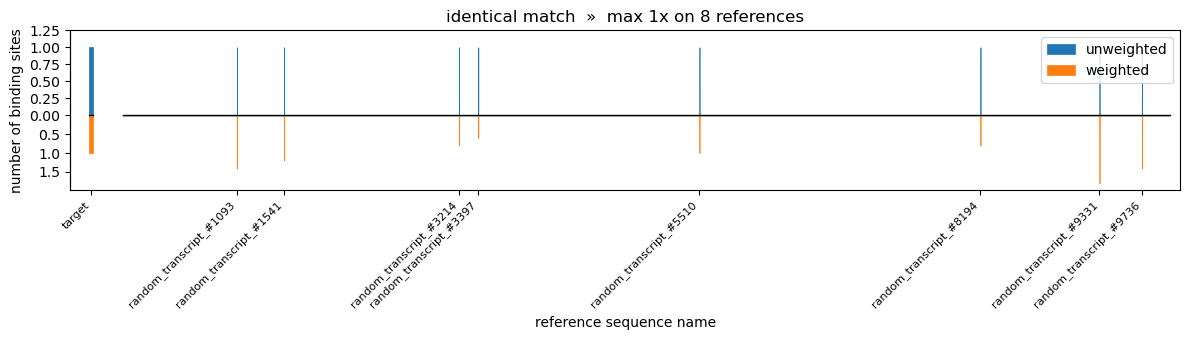

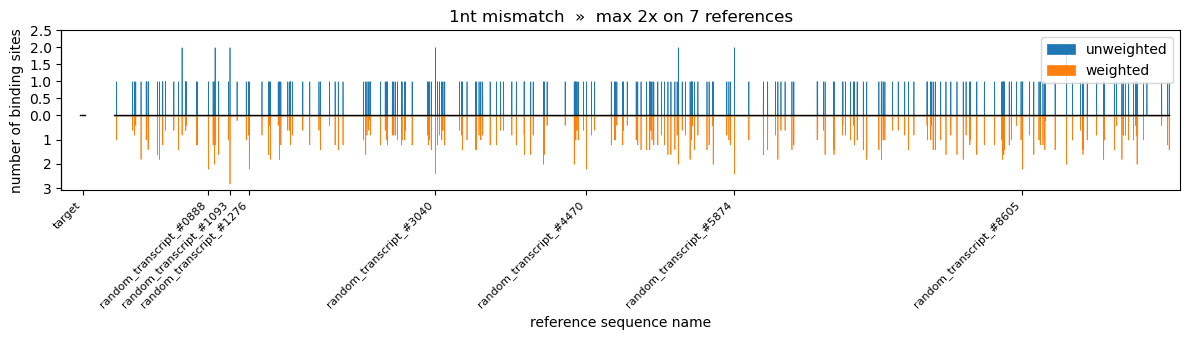

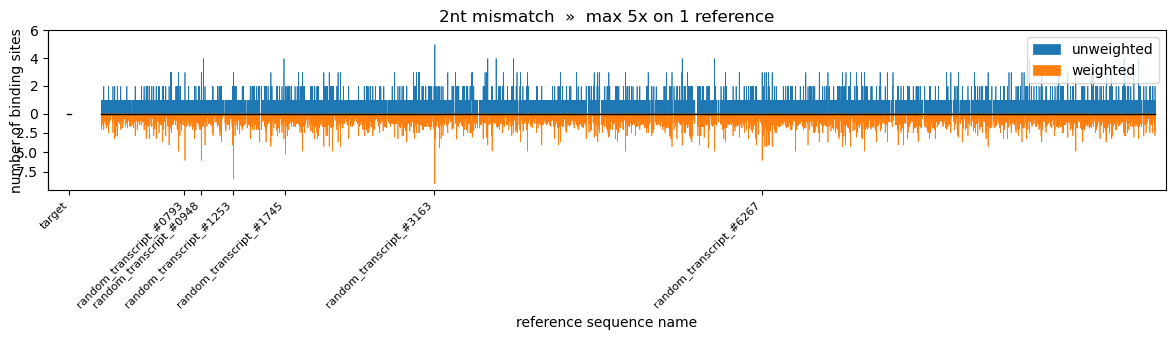

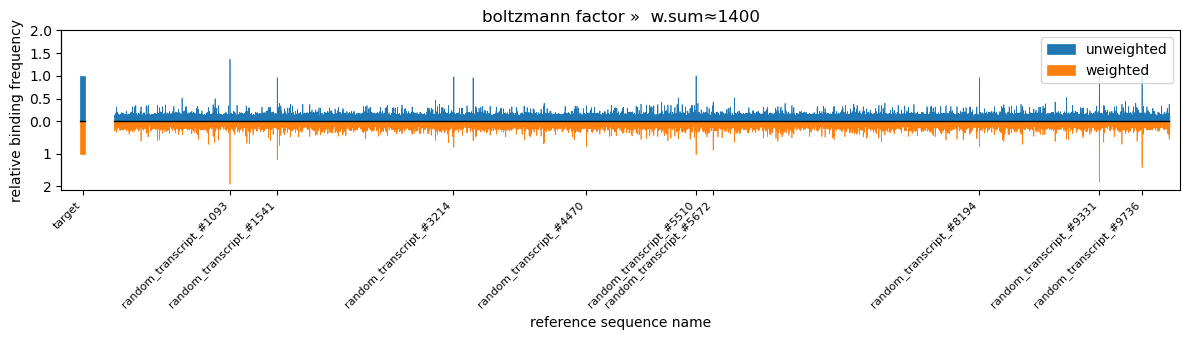

{'SEQUENCE': 'TCAGTTATTA',
 'SEQ_NAME': 'random_transcript_#9999',
 'identical match max': np.float64(1.0),
 'identical match sum': np.float64(8.0),
 'identical match VIR': array(['random_transcript_#1093', 'random_transcript_#1541',
        'random_transcript_#3214', 'random_transcript_#3397',
        'random_transcript_#5510', 'random_transcript_#8194',
        'random_transcript_#9331', 'random_transcript_#9736'], dtype=object),
 'identical match W.max': np.float64(1.8),
 'identical match W.sum': np.float64(9.0),
 'identical match W.VIR': array(['random_transcript_#9331', 'random_transcript_#1093',
        'random_transcript_#9736', 'random_transcript_#1541',
        'random_transcript_#5510', 'random_transcript_#3214',
        'random_transcript_#8194', 'random_transcript_#3397'], dtype=object),
 '1nt mismatch max': np.float64(2.0),
 '1nt mismatch sum': np.float64(268.0),
 '1nt mismatch VIR': array(['random_transcript_#0639', 'random_transcript_#0952',
        'random_transcript_#1

In [ ]:

#-------------------------------------------------------#
# summarize interaction of query with reference dataset #       # now that we have a huge and detailed list of the interaction with every of the thousands of reference sequences (i.e. transcripts), we need to summarize again to only a few metrics telling how much this query sequence interacts with the references overall
#-------------------------------------------------------#

# now that we have a huge and detailed list of the sequence comparison with every of the thousands of reference sequences (i.e. transcripts), we need to summarize again to only a few metrics telling how much this query sequence interacts with the references overall
query_summary = {"SEQUENCE": query.SEQUENCE, "SEQ_NAME": ref.SEQ_NAME}    
for i, col in enumerate(["identical match", "1nt mismatch", "2nt mismatch", "boltzmann factor"]): # iterate over all the metrics that should be summarized
    metRic = results_R[col]             # results of comparing the query i.e. candidate sequence against the reference dataset
    meTric = results_T[col][0]          # results of comparing the query i.e. candidate sequence against the target sequence
    if use_weights:
        wetRic =  results_R[col] * results_R["WEIGHT"]
        weTric = (results_T[col] * results_T["WEIGHT"])[0]

    if "match" in col:          # the mismatch count data is not re-normalized
        insert = ""
        norm = 1
        norw = 1
    elif "oltzman" in col:      # for the Boltzmann factor it is compared to the Boltzmann factor of the query sequence --> relative comparison of query binding to the target vs transcripts
        insert = " r2t"         # relative to target
        norm = meTric
        if use_weights: norw = weTric


    selec = ((metRic > sorted(metRic)[-min(10, len(metRic))]) | (metRic == metRic.max()) * (metRic != metRic.min())) ## (metRic > sorted(metRic)[-10]) returns the 10th largest value, also ever value equal to the largest one is included. Overrulling everything else is the exclusion of the min value
    VIR = results_R.iloc[metRic[selec].sort_values(ascending = False).index].SEQ_NAME  # Very Important References ; 
    query_summary[ col + f" max" + insert] = metRic.max() / norm        # What was the highest number of off-target binding sites on a single reference i.e. transcript
    query_summary[ col + f" sum" + insert] = metRic.sum() / norm        # What was the  total  number of off-target binding sites on the whole reference dataset i.e. transcriptome
    query_summary[ col + " VIR"] = VIR.values


    if use_weights:
        selec = ((wetRic > sorted(wetRic)[-min(10, len(wetRic))]) | (wetRic == wetRic.max()) * (wetRic != wetRic.min())) ## (metRic > sorted(metRic)[-10]) returns the 10th largest value, also ever value equal to the largest one is included. Overrulling everything else is the exclusion of the min value
        VIR = results_R.iloc[wetRic[selec].sort_values(ascending = False).index].SEQ_NAME  # Very Important References ; 
        query_summary[ col + f" W.max" + insert] = wetRic.max() / norw        # What was the highest number of off-target binding sites on a single reference i.e. transcript
        query_summary[ col + f" W.sum" + insert] = wetRic.sum() / norw        # What was the  total  number of off-target binding sites on the whole reference dataset i.e. transcriptome
        query_summary[ col + " W.VIR"] = VIR.values







    #------------------------------------------------------#
    #                 Plotting the results                 #   
    #------------------------------------------------------#

    if plot:
        def round(x, digits = 3):
            mag = -int(np.floor(np.log10(x))-digits+1)
            return np.round(x, mag).astype([int, float][int(mag > 0)])
        
        sy = 1
        if use_weights:
            if detailed_search_results[col].max() != 0 and (detailed_search_results[col]*detailed_search_results.WEIGHT).max() != 0 and (detailed_search_results[col]*detailed_search_results.WEIGHT).min() >= 0:
                sy = detailed_search_results[col].max() / (detailed_search_results[col]*detailed_search_results.WEIGHT).max() # internal rescaling factor for the split y axis

        xmax = len(metRic)
        fig, ax = plt.subplots(1, 1, figsize = (12, 3 + .5*int(use_weights)))
        ax.plot([0, xmax],                [0, 0], zorder = 10, color = "black", lw = 1) # plot black zero line for references
        ax.plot([-.032*xmax, -.028*xmax], [0, 0], zorder = 10, color = "black", lw = 1) # plot black zero line for target
        ax.fill_between(np.arange(xmax),           metRic/norm,              metRic*0, color = "tab:blue", ec = "tab:blue", lw = .5, label = "unweighted")    # plot unweighted results of references
        ax.fill_between([-.032*xmax, -.028*xmax], [meTric/norm, meTric/norm], [0,0],   color = "tab:blue", ec = "tab:blue", lw = .5)                          # plot unweighted results of target

        if use_weights:
            ax.fill_between(np.arange(xmax),           -wetRic*sy/norw,                   wetRic*0,  color = "tab:orange", ec = "tab:orange", lw = .5, label = "weighted")           # plot weighted results of references
            ax.fill_between([-.032*xmax, -.028*xmax], [-weTric*sy/norw, -weTric*sy/norw], [0,0],     color = "tab:orange", ec = "tab:orange", lw = .5)                               # plot weighted results of target
            ax.legend(loc = "upper right")

        insert = "" # for figure titles
        if "match" in col: # for the (mis) match count data
            ax.set_ylabel("number of binding sites")
            if metRic.max() > 0:  # i.e. if there are mismatches to plot.
                insert = f"  »  max {metRic.max()}x on {(metRic == metRic.max()).sum()} reference{'s'*int((metRic == metRic.max()).sum() != 1)}"
        elif "oltzma" in col: # for the bpötzmann factors
            if use_weights:  insert =  f" »  w.sum≈{round(wetRic.sum()/norw)}"
            else:            insert =  f" »  sum≈{  round(metRic.sum()/norm)}"
            ax.set_ylabel("relative binding frequency")

        ax.set_title(col + insert)

        # x-axis formatting
        ax.set_xlabel("reference sequence name")
        ax.set_xticks(np.concatenate([[-0.03*xmax], VIR.index]), labels = np.concatenate([["target"], VIR.values]), fontsize = 8, rotation = 45,  ha='right')
        ax.set_xlim(-0.05*xmax, 1.01*xmax)
    
        # split y axis formatting
        yt = ax.get_yticks().copy()
        ax.set_yticks(yt[yt>=0])
        sec_y = ax.secondary_yaxis("left", functions = (lambda y: -y/sy, lambda y: -y*sy))
        plt.tight_layout() # need to be called before getting ytick values as this triggers matplotlib to calculate the layout and the ticks correctly.
        yt2 = sec_y.get_yticks()
        sec_y.set_yticks(yt2[yt2>0])
        
        plt.show()

query_summary

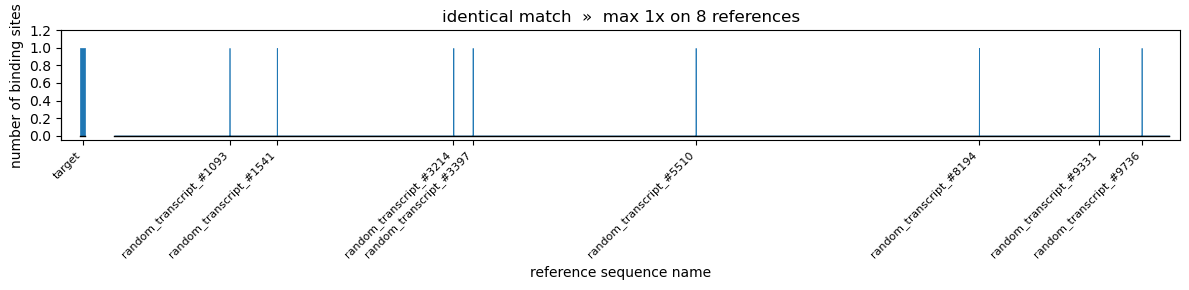

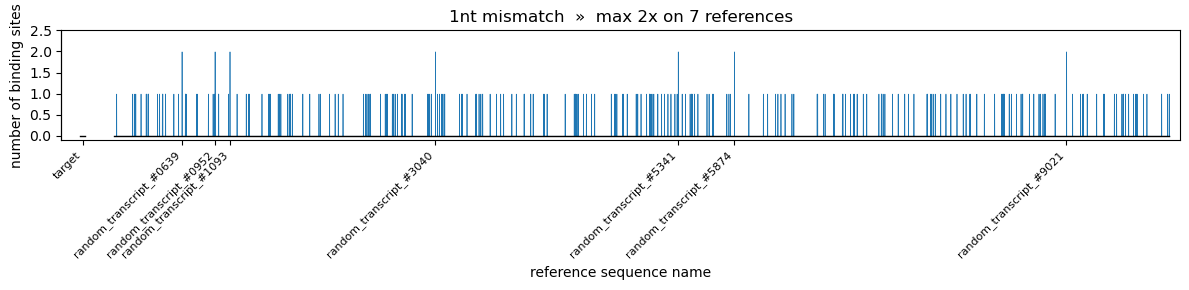

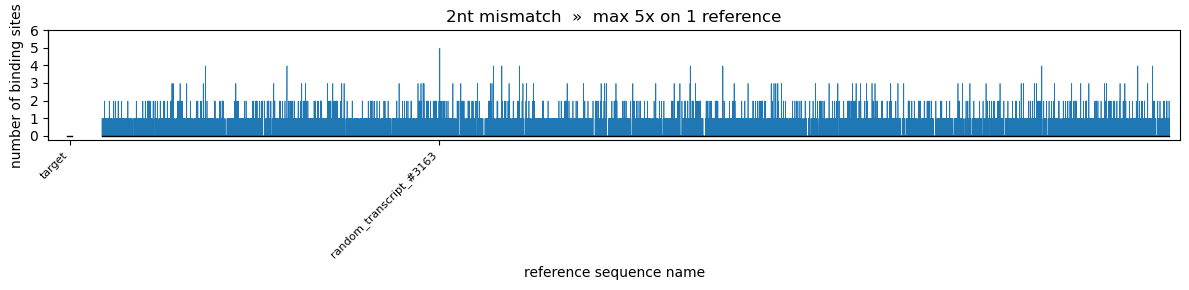

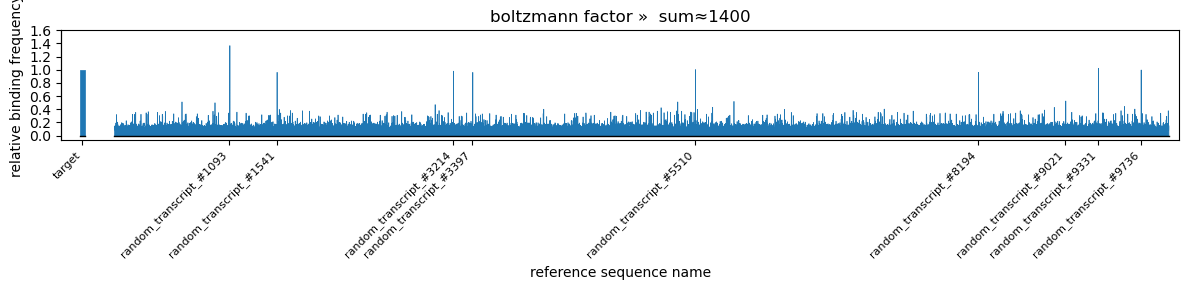

{'SEQUENCE': 'TCAGTTATTA',
 'SEQ_NAME': 'random_transcript_#9999',
 'identical match max': np.float64(1.0),
 'identical match sum': np.float64(8.0),
 'identical match VIR': array(['random_transcript_#1093', 'random_transcript_#1541',
        'random_transcript_#3214', 'random_transcript_#3397',
        'random_transcript_#5510', 'random_transcript_#8194',
        'random_transcript_#9331', 'random_transcript_#9736'], dtype=object),
 '1nt mismatch max': np.float64(2.0),
 '1nt mismatch sum': np.float64(268.0),
 '1nt mismatch VIR': array(['random_transcript_#0639', 'random_transcript_#0952',
        'random_transcript_#1093', 'random_transcript_#3040',
        'random_transcript_#5341', 'random_transcript_#5874',
        'random_transcript_#9021'], dtype=object),
 '2nt mismatch max': np.float64(5.0),
 '2nt mismatch sum': np.float64(3897.0),
 '2nt mismatch VIR': array(['random_transcript_#3163'], dtype=object),
 'boltzmann factor max r2t': np.float64(1.3749507521896775),
 'boltzmann factor

In [ ]:

def round(x, digits = 3):
        mag = -int(np.floor(np.log10(x))-digits+1)
        return np.round(x, mag).astype([int, float][int(mag > 0)])


### just a copy of the cells above wrapped into a function 

def query_eval(query, reference_dataset, plot = False, use_weights=True):
    '''searches for (partial) matches between query sequence and reference dataset
    query: sequence to be found (pd.Series object)
    reference_dataset: pd.DataFrame of sequences to test against
    Both need at least a SEQ_NAME and a SEQUENCE column
    '''

    #-------------------------------------------------#
    #              input arguments check              #
    #-------------------------------------------------#

    if not ("SEQ_NAME" in reference_dataset.columns and "SEQUENCE" in reference_dataset.columns):
        raise ValueError('reference_dataset does not contain required columns: SEQ_NAME, SEQUENCE')

    if type(query) == pd.Series:  pass # everything is fine
    elif type(query) == str:           # convert to pandas series
        warnings.warn("Warning, deprecated input type for query: string. Please use pandas.Series!")
        query = pd.Series({"SEQ_NAME": "unnamed", "SEQUENCE": query})
    elif type(query) == pd.DataFrame and len(query) == 1:
        query = query.iloc[0]
    else: raise ValueError("unsupported type for 'query', use pandas.Series")

    if type(reference_dataset) == pd.DataFrame: pass # everything is fine
    else: raise ValueError("unsopported type for 'reference_dataset', use pandas.DataFrame")

    nts = set(reference_dataset.SEQUENCE.sample(100).sum()) | set(target_sequence.SEQUENCE)
    if len(nts) != 4: # check how many nucleotides are used
        warnings.warn(f"Warning, expected 4 types of nucleoties in the input, found (at least) {len(nts)}")

    joined_DF = pd.concat([pd.DataFrame([target_sequence]), reference_dataset], axis = 0)  # add the target itself to the dataset to check against

    if use_weights:  # check if the input data is okay to use weighted evalutation
        if "WEIGHT" in joined_DF.columns:
            invalid = joined_DF.WEIGHT.isin([np.inf, -np.inf, np.nan])
            if invalid.any():  
                warnings.warn(f"{invalid.sum()} entries with nan or inf WEIGHT. The script might not behave as intended.")
        else: 
            print("No WEIGHT column found, switching 'use_weights = False'")
            use_weights = False

    #-------------------------------------------------#
    #  Search for binding sites in reference dataset  #
    #-------------------------------------------------#
    
    detailed_search_results = pd.DataFrame()                     # initialize a dataset to store the results of comparing query sequence with every reference i.e. every transcript in the transcriptome

    ### check type and encode if not already done (makes it run faster, dunno why)
    if type(query.SEQUENCE) == str:  q_seq = query.SEQUENCE.encode()
    elif type(query.SEQUENCE) == bytes: q_seq = query.SEQUENCE
    else: raise ValueError(f"unsuppported type for query sequence: {type(query.SEQUENCE)}")

    for i, ref in joined_DF.iterrows():                          # iterate over all reference sequences. and the target itself as control 

        ### check type and encode if not already done (makes it run faster, dunno why)
        if type(ref.SEQUENCE) == str:  r_seq = ref.SEQUENCE.encode()
        elif type(ref.SEQUENCE) == bytes: r_seq = ref.SEQUENCE
        else: raise ValueError(f"unsuppported type for query sequence: {type(ref.SEQUENCE)}")

        mm = len(q_seq)-sc_jit(q_seq, r_seq)                      # number of mismatches per position # utf8 encoding of strings to integers speeds up the comparison for some reason
        sc_row = {"SEQ_NAME": ref.SEQ_NAME}                       # summarize the possible binding sites of the query sequence against one reference sequence (here a transcript)
        if use_weights: sc_row |= {"WEIGHT":ref.WEIGHT}      
        sc_row["identical match"] = (mm==0).sum()                 # number of idential matches
        sc_row["1nt mismatch"]    = (mm==1).sum()                 # number of sites with 1 mismatch
        sc_row["2nt mismatch"]    = (mm==2).sum()                 # number of sites with 2 mistmatches
        sc_row["boltzmann factor"] = np.sum(np.exp(-1.5*mm))      # a very basic prediction of how likely the query sequence would bind to the reference. The wildtype pumilios have ~ 18 hydrogen bonds for 8nt i.e. 2.25 hydgrogen bonds = 2.25kT per bp, however the pumby appears to only have ~2 H-bonds per bp, and the binding statistics suggest closer to 1kT -> lets go with 1.5 for now, in the future a more accurate model might be implemented. Currently the boltzmann_factor for a perfect match is 1, if therefore this predicted boltzmann_factor is smaller than 1 than it is more likly to bind to the specific RNA, while if it is larger than one it is more likely to bind to the background transcriptom 
        
        detailed_search_results = pd.concat([detailed_search_results, pd.DataFrame([sc_row])], ignore_index=True) # add the results for this reference (here transcript) to the dataset

    results_R = detailed_search_results.loc[~(detailed_search_results.SEQ_NAME == target_sequence.SEQ_NAME)].reset_index(drop = True) # results from the comparison with the reference dataset (sqeuences to avoid)
    results_T = detailed_search_results.loc[  detailed_search_results.SEQ_NAME == target_sequence.SEQ_NAME].reset_index(drop = True)  # results from the comparison with the target sequence
    if len(results_T) > 1: # there should only be one entry for the target
        raise ValueError("unexpected result, there should only be one entry")

    
    #-------------------------------------------------------#
    # summarize interaction of query with reference dataset #       # now that we have a huge and detailed list of the interaction with every of the thousands of reference sequences (i.e. transcripts), we need to summarize again to only a few metrics telling how much this query sequence interacts with the references overall
    #-------------------------------------------------------#

    # now that we have a huge and detailed list of the sequence comparison with every of the thousands of reference sequences (i.e. transcripts), we need to summarize again to only a few metrics telling how much this query sequence interacts with the references overall
    query_summary = {"SEQUENCE": query.SEQUENCE, "SEQ_NAME": ref.SEQ_NAME}    
    for i, col in enumerate(["identical match", "1nt mismatch", "2nt mismatch", "boltzmann factor"]): # iterate over all the metrics that should be summarized
        metRic = results_R[col]             # results of comparing the query i.e. candidate sequence against the reference dataset
        meTric = results_T[col][0]          # results of comparing the query i.e. candidate sequence against the target sequence
        if use_weights:
            wetRic =  results_R[col] * results_R["WEIGHT"]
            weTric = (results_T[col] * results_T["WEIGHT"])[0]

        if "match" in col:          # the mismatch count data is not re-normalized
            insert = ""
            norm = 1
            norw = 1
        elif "oltzman" in col:      # for the Boltzmann factor it is compared to the Boltzmann factor of the query sequence --> relative comparison of query binding to the target vs transcripts
            insert = " r2t"         # relative to target
            norm = meTric
            if use_weights: norw = weTric


        selec = ((metRic > sorted(metRic)[-min(10, len(metRic))]) | (metRic == metRic.max()) * (metRic != metRic.min())) ## (metRic > sorted(metRic)[-10]) returns the 10th largest value, also ever value equal to the largest one is included. Overrulling everything else is the exclusion of the min value
        VIR = results_R.iloc[metRic[selec].sort_values(ascending = False).index].SEQ_NAME  # Very Important References ; 
        query_summary[ col + f" max" + insert] = metRic.max() / norm        # What was the highest number of off-target binding sites on a single reference i.e. transcript
        query_summary[ col + f" sum" + insert] = metRic.sum() / norm        # What was the  total  number of off-target binding sites on the whole reference dataset i.e. transcriptome
        query_summary[ col + " VIR"] = VIR.values


        if use_weights:
            selec = ((wetRic > sorted(wetRic)[-min(10, len(wetRic))]) | (wetRic == wetRic.max()) * (wetRic != wetRic.min())) ## (metRic > sorted(metRic)[-10]) returns the 10th largest value, also ever value equal to the largest one is included. Overrulling everything else is the exclusion of the min value
            VIR = results_R.iloc[wetRic[selec].sort_values(ascending = False).index].SEQ_NAME  # Very Important References ; 
            query_summary[ col + f" W.max" + insert] = wetRic.max() / norw        # What was the highest number of off-target binding sites on a single reference i.e. transcript
            query_summary[ col + f" W.sum" + insert] = wetRic.sum() / norw        # What was the  total  number of off-target binding sites on the whole reference dataset i.e. transcriptome
            query_summary[ col + " W.VIR"] = VIR.values




        #------------------------------------------------------#
        #                 Plotting the results                 #   
        #------------------------------------------------------#

        if plot:
            def round(x, digits = 3):
                mag = -int(np.floor(np.log10(x))-digits+1)
                return np.round(x, mag).astype([int, float][int(mag > 0)])
            
            sy = 1
            if use_weights:
                if detailed_search_results[col].max() != 0 and (detailed_search_results[col]*detailed_search_results.WEIGHT).max() != 0 and (detailed_search_results[col]*detailed_search_results.WEIGHT).min() >= 0:
                    sy = detailed_search_results[col].max() / (detailed_search_results[col]*detailed_search_results.WEIGHT).max() # internal rescaling factor for the split y axis

            xmax = len(metRic)
            fig, ax = plt.subplots(1, 1, figsize = (12, 3 + .5*int(use_weights)))
            ax.plot([0, xmax],                [0, 0], zorder = 10, color = "black", lw = 1) # plot black zero line for references
            ax.plot([-.032*xmax, -.028*xmax], [0, 0], zorder = 10, color = "black", lw = 1) # plot black zero line for target
            ax.fill_between(np.arange(xmax),           metRic/norm,              metRic*0, color = "tab:blue", ec = "tab:blue", lw = .5, label = "unweighted")    # plot unweighted results of references
            ax.fill_between([-.032*xmax, -.028*xmax], [meTric/norm, meTric/norm], [0,0],   color = "tab:blue", ec = "tab:blue", lw = .5)                          # plot unweighted results of target

            if use_weights:
                ax.fill_between(np.arange(xmax),           -wetRic*sy/norw,                   wetRic*0,  color = "tab:orange", ec = "tab:orange", lw = .5, label = "weighted")           # plot weighted results of references
                ax.fill_between([-.032*xmax, -.028*xmax], [-weTric*sy/norw, -weTric*sy/norw], [0,0],     color = "tab:orange", ec = "tab:orange", lw = .5)                               # plot weighted results of target
                ax.legend(loc = "upper right")

            insert = "" # for figure titles
            if "match" in col: # for the (mis) match count data
                ax.set_ylabel("number of binding sites")
                if metRic.max() > 0:  # i.e. if there are mismatches to plot.
                    insert = f"  »  max {metRic.max()}x on {(metRic == metRic.max()).sum()} reference{'s'*int((metRic == metRic.max()).sum() != 1)}"
            elif "oltzma" in col: # for the bpötzmann factors
                if use_weights:  insert =  f" »  w.sum≈{round(wetRic.sum()/norw)}"
                else:            insert =  f" »  sum≈{  round(metRic.sum()/norm)}"
                ax.set_ylabel("relative binding frequency")

            ax.set_title(col + insert)

            # x-axis formatting
            ax.set_xlabel("reference sequence name")
            ax.set_xticks(np.concatenate([[-0.03*xmax], VIR.index]), labels = np.concatenate([["target"], VIR.values]), fontsize = 8, rotation = 45,  ha='right')
            ax.set_xlim(-0.05*xmax, 1.01*xmax)
        
            # split y axis formatting
            yt = ax.get_yticks().copy()
            ax.set_yticks(yt[yt>=0])
            sec_y = ax.secondary_yaxis("left", functions = (lambda y: -y/sy, lambda y: -y*sy))
            plt.tight_layout() # need to be called before getting ytick values as this triggers matplotlib to calculate the layout and the ticks correctly.
            yt2 = sec_y.get_yticks()
            sec_y.set_yticks(yt2[yt2>0])
            
            plt.show()


    return query_summary


query_eval(query, reference_dataset, True, False)

<br>   

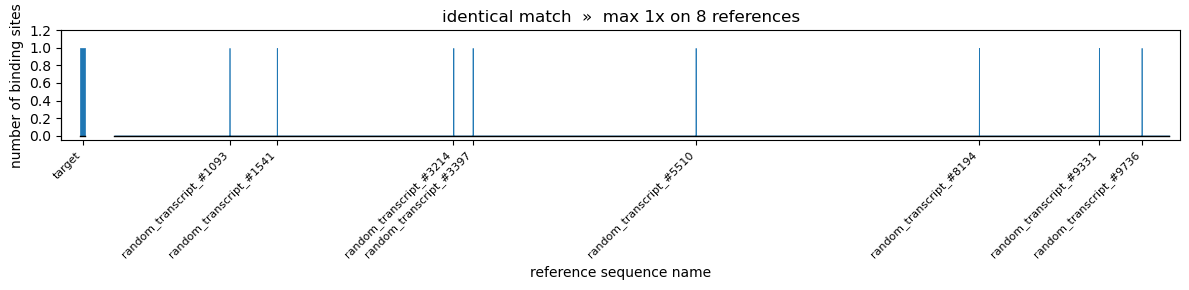

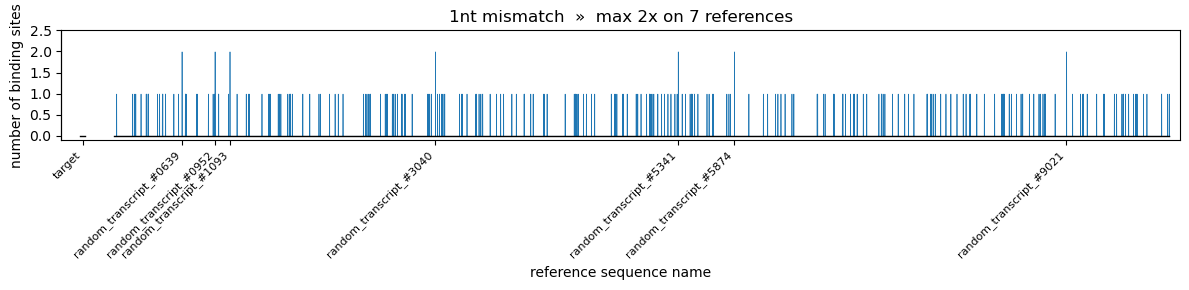

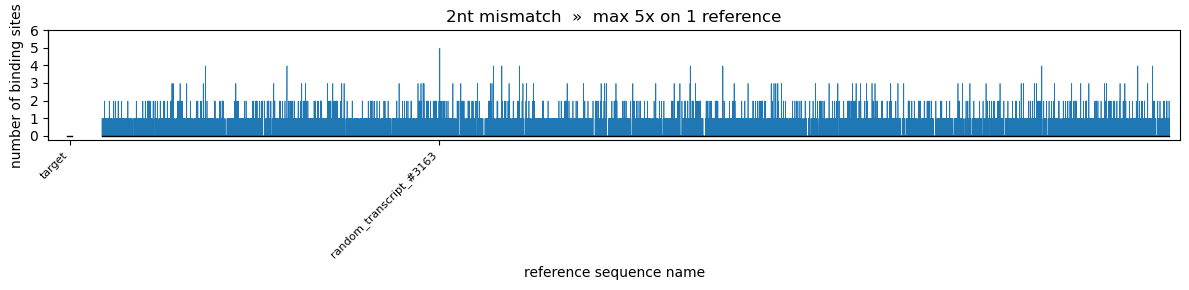

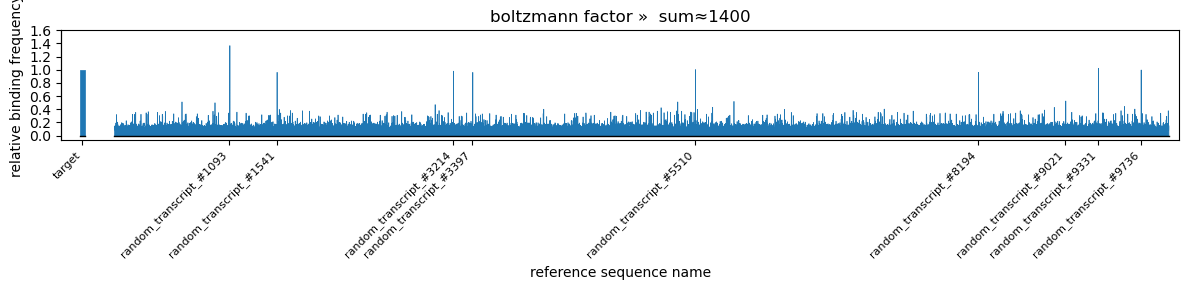

{'SEQUENCE': 'TCAGTTATTA',
 'SEQ_NAME': 'random_transcript_#9999',
 'identical match max': np.float64(1.0),
 'identical match sum': np.float64(8.0),
 'identical match VIR': array(['random_transcript_#1093', 'random_transcript_#1541',
        'random_transcript_#3214', 'random_transcript_#3397',
        'random_transcript_#5510', 'random_transcript_#8194',
        'random_transcript_#9331', 'random_transcript_#9736'], dtype=object),
 '1nt mismatch max': np.float64(2.0),
 '1nt mismatch sum': np.float64(268.0),
 '1nt mismatch VIR': array(['random_transcript_#0639', 'random_transcript_#0952',
        'random_transcript_#1093', 'random_transcript_#3040',
        'random_transcript_#5341', 'random_transcript_#5874',
        'random_transcript_#9021'], dtype=object),
 '2nt mismatch max': np.float64(5.0),
 '2nt mismatch sum': np.float64(3897.0),
 '2nt mismatch VIR': array(['random_transcript_#3163'], dtype=object),
 'boltzmann factor max r2t': np.float64(1.3749507521896775),
 'boltzmann factor

In [10]:
#query = query_dataset.sample()
query_eval(query, reference_dataset, True, False)


# Now query all possible candidate sequences from the target (in parallel)


In [11]:
# generate input sequences
reference_dataset = pd.DataFrame([{"SEQ_NAME": f"random_transcript_#{i:04d}", "SEQUENCE": random_seq(size = 10**3), "WEIGHT": np.random.poisson(5)/5} for i in range(10000)])  # The reference to check against, i.e. a transcript from the transcriptome in this example
target_sequence   = pd.Series(    {"SEQ_NAME": "random_target",               "SEQUENCE": random_seq(size = 800),   "WEIGHT": 1})                                                  # The sequence from which we want ot find the best/unique binding site
binding_site_len = 12  # length of the binding sites (8-12 for pumby)
plot = False

In [12]:
# retrieve all possible binding sites of the target sequence
query_dataset = pd.DataFrame([{"SEQ_NAME": target_sequence.SEQ_NAME + f"_{k}:{k+binding_site_len}", "SEQUENCE":target_sequence.SEQUENCE[k:k+binding_site_len]} for k in range(len(target_sequence.SEQUENCE)-binding_site_len)] )
query_dataset  

SEQ_NAME      SEQUENCE
0       random_target_0:12  TGTACGGTAGTG
1       random_target_1:13  GTACGGTAGTGT
2       random_target_2:14  TACGGTAGTGTC
3       random_target_3:15  ACGGTAGTGTCA
4       random_target_4:16  CGGTAGTGTCAA
..                     ...           ...
783  random_target_783:795  AGACAATTATAC
784  random_target_784:796  GACAATTATACA
785  random_target_785:797  ACAATTATACAA
786  random_target_786:798  CAATTATACAAT
787  random_target_787:799  AATTATACAATG

[788 rows x 2 columns]

In [13]:
%timeit query_eval(query_dataset.sample(), reference_dataset, plot = False, use_weights = True)
%timeit query_eval(query_dataset.sample(), reference_dataset, plot = False, use_weights = False)

4.81 s ± 10.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.91 s ± 47.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
#-------------------------------#
#  Parallel processing: joblib  #  
#-------------------------------#          # using joblib instead of multiprocessing becasue of windows compatibility
from joblib import Parallel, delayed
from tqdm import tqdm
scores = list(Parallel(n_jobs=-1)(delayed(query_eval)(query, reference_dataset) for row_ID, query in tqdm(query_dataset.iterrows(), total=len(query_dataset), ncols = 100)))

100%|█████████████████████████████████████████████████████████████| 788/788 [04:50<00:00,  2.72it/s]


# Visualize results

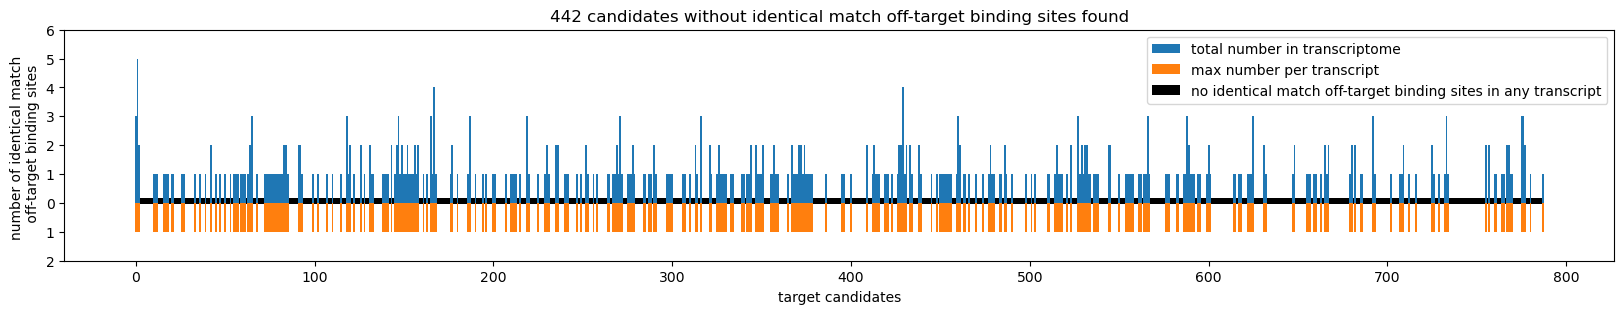

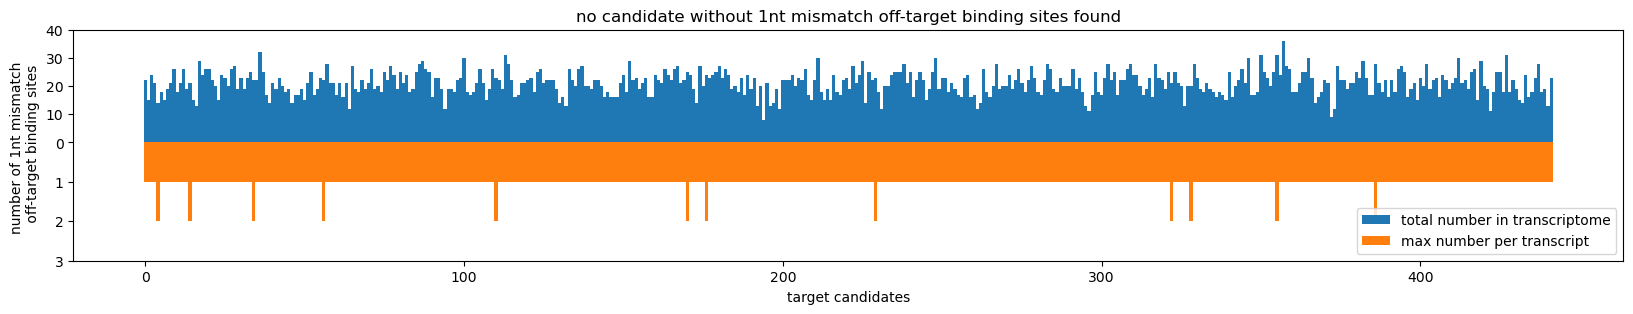

continue with 442 candidates


In [15]:

## Visualize the the offtarget binding sites for every candidate sequence ## 
selections = []
df = pd.DataFrame(scores)
for col in ["identical match", "1nt mismatch", "2nt mismatch"]:
    col1 = col + f' sum'
    col2 = col + f' max'
    sel = df[df[col1]==0]
    selections.append(sel)
    
    plt.figure(figsize = (20, 3))
    sy = np.round(0.66 * df[col1].mean() / df[col2].mean(), 0).astype(int) # rescaling for the lower half of the plot, only visual
    plt.bar(df.index,  df[col1].values, label = "total number in transcriptome", width = 1)
    plt.bar(df.index, -df[col2].values*sy,  label = "max number per transcript", width = 1)
    if len(sel) > 0:
        plt.bar(sel.index, .04*df[col1].max(), bottom = -.02*df[col2].max()*sy, label = f"no {col} off-target binding sites in any transcript", color = "black", width = 1)
    plt.xlabel("target candidates")
    plt.ylabel(f"number of {col} \n off-target binding sites");
    yl = plt.yticks()[0]
    yl[yl<0] /= sy
    yl = np.unique(yl.round().astype(int))
    yt = yl.copy()
    yt[yt<0] *= sy
    plt.yticks(yt, np.abs(yl))
    plt.legend();

    if len(sel) == 0:
        plt.title(f"no candidate without {col} off-target binding sites found")
        plt.show()
        break;

    else: 
        df = sel.reset_index(drop = True)  # select only those with fewest number of offtarget binding sites
        plt.title(f"{len(sel)} candidates without {col} off-target binding sites found")
    plt.show()
select = df.copy()
print(f"continue with {len(select)} candidates")

### maybe do a PCA to visualize the selected / filtered datapoints in the context of all datapoints

In [16]:
numeric_df = select.select_dtypes(include='number')
filtered = df.iloc[numeric_df[(numeric_df <= numeric_df.median()).all(axis = 1)].index]
filtered


SEQUENCE                 SEQ_NAME  identical match max  \
13   CGCCGCGCTAGG  random_transcript_#9999                  0.0   
60   CCCGGTTCATGA  random_transcript_#9999                  0.0   
84   CTTGCACTAATT  random_transcript_#9999                  0.0   
93   GCCCAATGACTC  random_transcript_#9999                  0.0   
96   ATGACTCACGGA  random_transcript_#9999                  0.0   
101  ACGGATATGCTA  random_transcript_#9999                  0.0   
102  GGATATGCTACT  random_transcript_#9999                  0.0   
103  GATATGCTACTC  random_transcript_#9999                  0.0   
129  GGCCATATACCC  random_transcript_#9999                  0.0   
145  GCACATCCAAGT  random_transcript_#9999                  0.0   
221  TCGAATTGGATT  random_transcript_#9999                  0.0   
275  ACGGCCGCTGGA  random_transcript_#9999                  0.0   
335  CGCCCCAATTGA  random_transcript_#9999                  0.0   
336  GCCCCAATTGAA  random_transcript_#9999                  0.0   
342  ATTGAAGAATCG  random_transcript_#9999                  0.0   
347  AATCGAAGTCCG  random_transcript_#9999                  0.0   
348  ATCGAAGTCCGA  random_transcript_#9999                  0.0   
423  CACTCCCCATGT  random_transcript_#9999                  0.0   

     identical match sum identical match VIR  identical match W.max  \
13                   0.0                  []                    0.0   
60                   0.0                  []                    0.0   
84                   0.0                  []                    0.0   
93                   0.0                  []                    0.0   
96                   0.0                  []                    0.0   
101                  0.0                  []                    0.0   
102                  0.0                  []                    0.0   
103                  0.0                  []                    0.0   
129                  0.0                  []                    0.0   
145                  0.0                  []                    0.0   
221                  0.0                  []                    0.0   
275                  0.0                  []                    0.0   
335                  0.0                  []                    0.0   
336                  0.0                  []                    0.0   
342                  0.0                  []                    0.0   
347                  0.0                  []                    0.0   
348                  0.0                  []                    0.0   
423                  0.0                  []                    0.0   

     identical match W.sum identical match W.VIR  1nt mismatch max  \
13                     0.0                    []               1.0   
60                     0.0                    []               1.0   
84                     0.0                    []               1.0   
93                     0.0                    []               1.0   
96                     0.0                    []               1.0   
101                    0.0                    []               1.0   
102                    0.0                    []               1.0   
103                    0.0                    []               1.0   
129                    0.0                    []               1.0   
145                    0.0                    []               1.0   
221                    0.0                    []               1.0   
275                    0.0                    []               1.0   
335                    0.0                    []               1.0   
336                    0.0                    []               1.0   
342                    0.0                    []               1.0   
347                    0.0                    []               1.0   
348                    0.0                    []               1.0   
423                    0.0                    []               1.0   

     1nt mismatch sum  ...                            

C:\Users\T3D\AppData\Local\Temp\ipykernel_12056\3573463565.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select["rank max"] = 0
C:\Users\T3D\AppData\Local\Temp\ipykernel_12056\3573463565.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select["rank sum"] = 0
C:\Users\T3D\AppData\Local\Temp\ipykernel_12056\3573463565.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

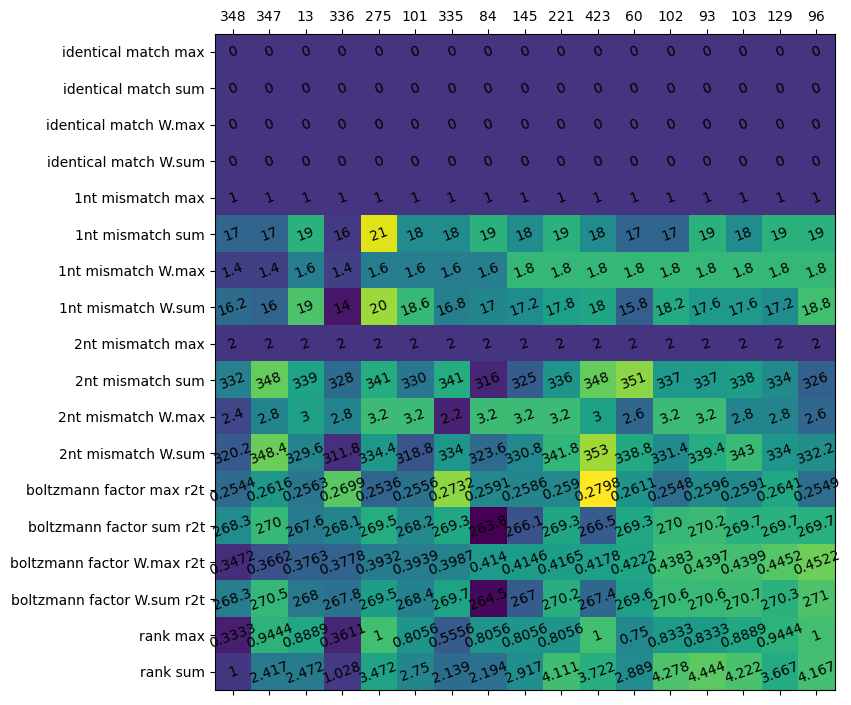


----------------------------------------------------------------------------------------------------
SEQUENCE                                                           ATCGAAGTCCGA
SEQ_NAME                                                random_transcript_#9999
identical match max                                                         0.0
identical match sum                                                         0.0
identical match VIR                                                          []
identical match W.max                                                       0.0
identical match W.sum                                                       0.0
identical match W.VIR                                                        []
1nt mismatch max                                                            1.0
1nt mismatch sum                                                           17.0
1nt mismatch VIR              [random_transcript_#0771, random_transcript_#3...
1nt mismatch W.max

C:\Users\T3D\AppData\Local\Temp\ipykernel_12056\3604443692.py:24: UserWarning: Warning, deprecated input type for query: string. Please use pandas.Series!
  warnings.warn("Warning, deprecated input type for query: string. Please use pandas.Series!")


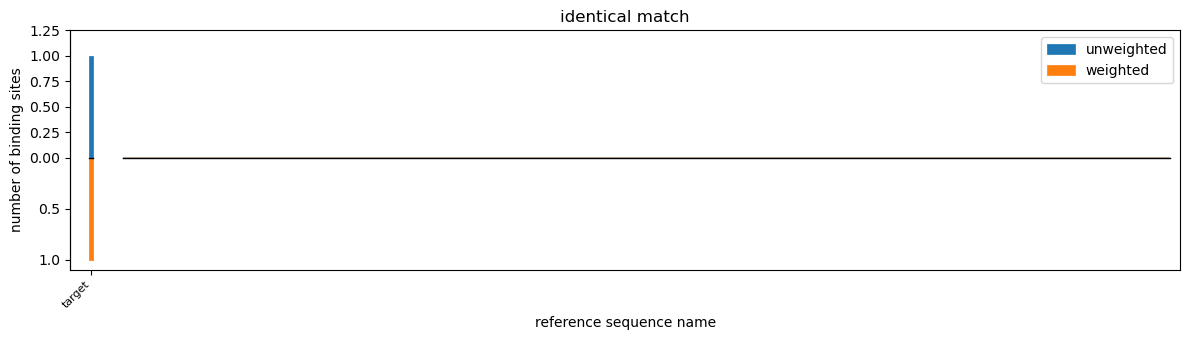

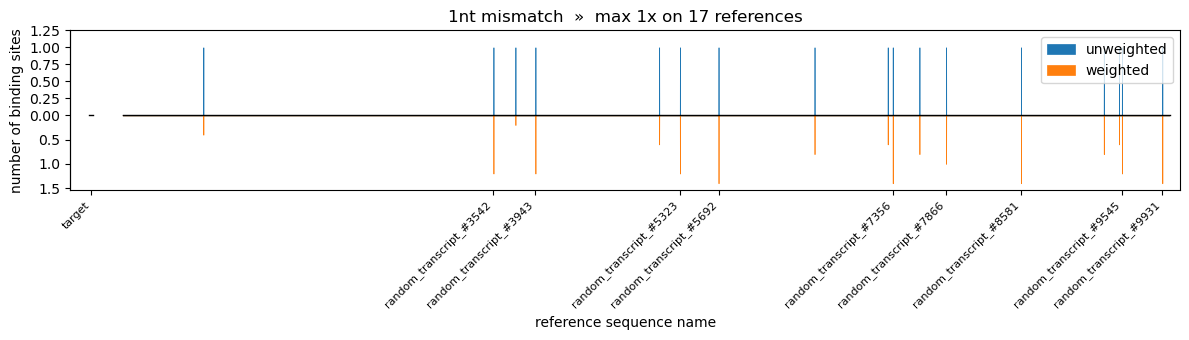

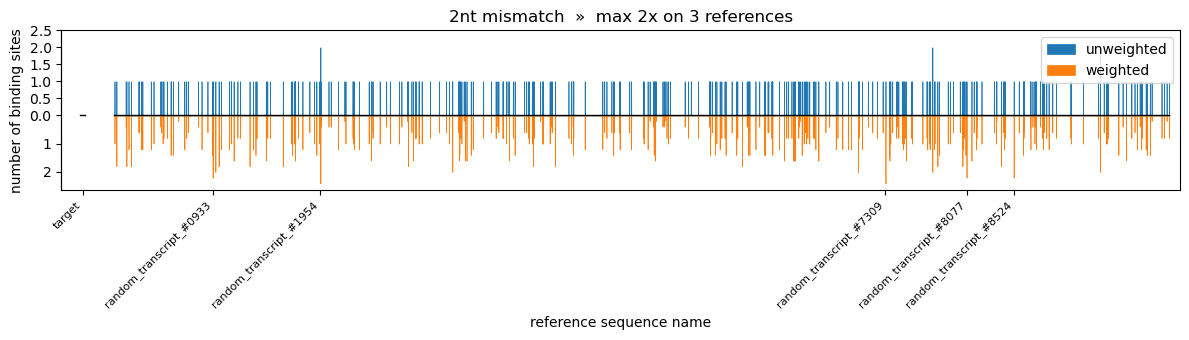

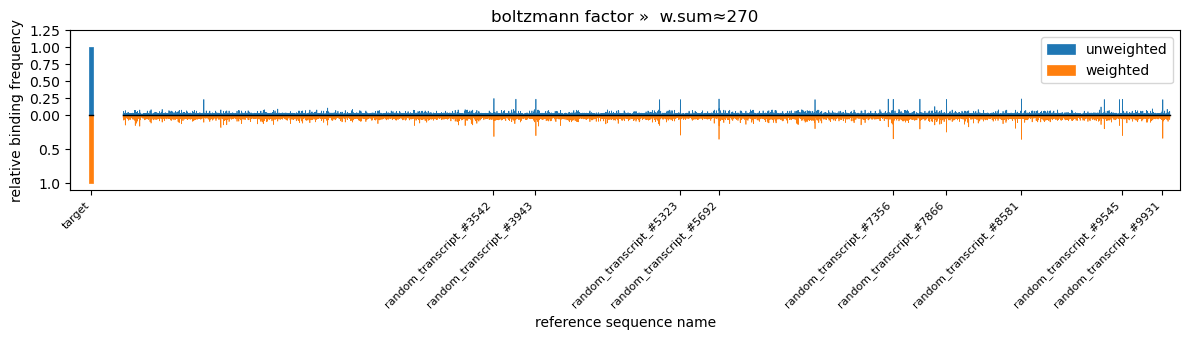


----------------------------------------------------------------------------------------------------
SEQUENCE                                                           AATCGAAGTCCG
SEQ_NAME                                                random_transcript_#9999
identical match max                                                         0.0
identical match sum                                                         0.0
identical match VIR                                                          []
identical match W.max                                                       0.0
identical match W.sum                                                       0.0
identical match W.VIR                                                        []
1nt mismatch max                                                            1.0
1nt mismatch sum                                                           17.0
1nt mismatch VIR              [random_transcript_#0459, random_transcript_#1...
1nt mismatch W.max

C:\Users\T3D\AppData\Local\Temp\ipykernel_12056\3604443692.py:24: UserWarning: Warning, deprecated input type for query: string. Please use pandas.Series!
  warnings.warn("Warning, deprecated input type for query: string. Please use pandas.Series!")


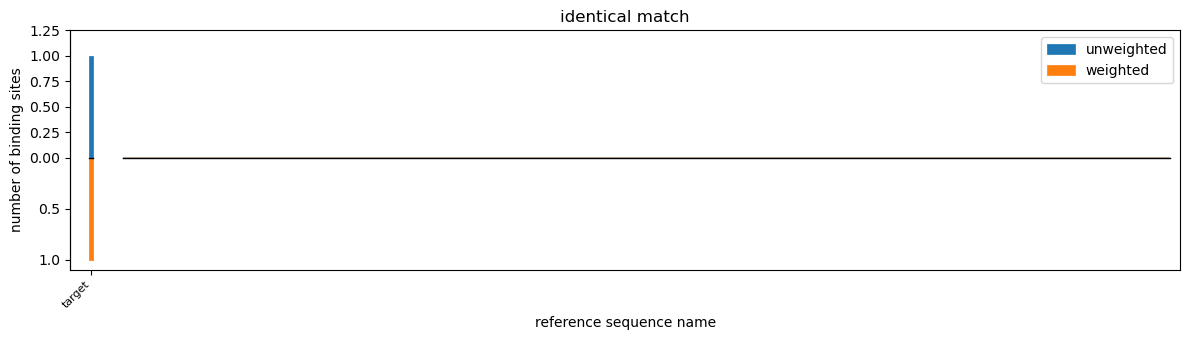

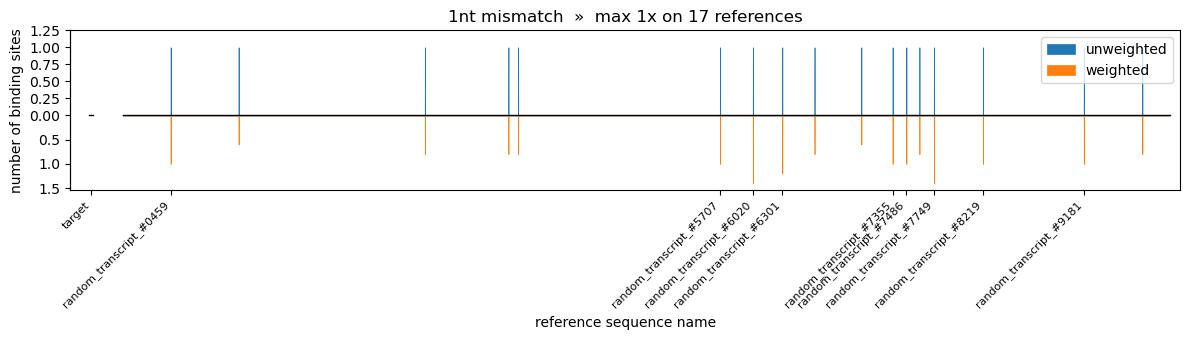

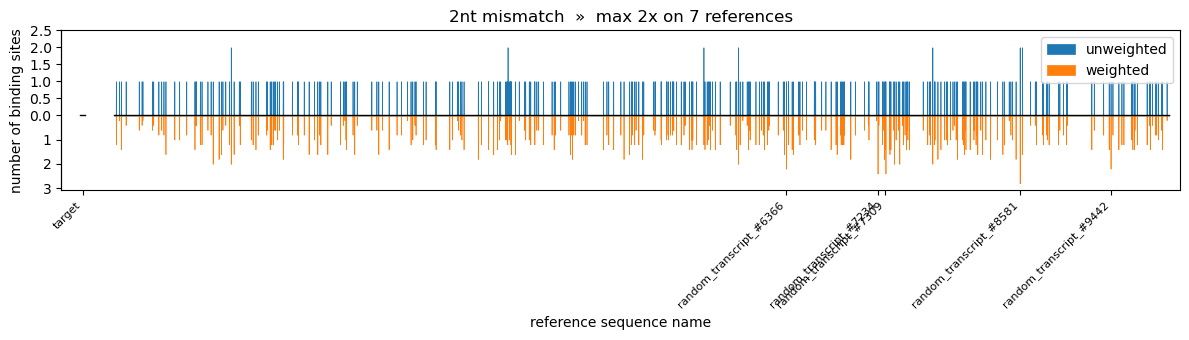

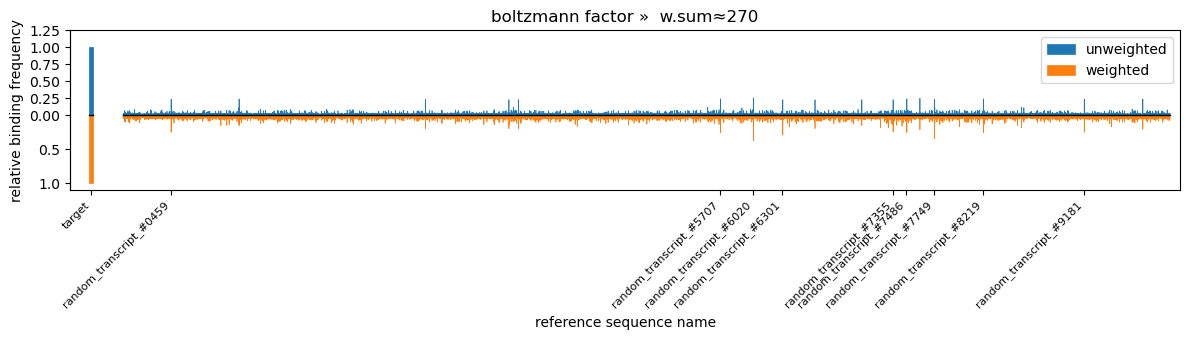


----------------------------------------------------------------------------------------------------
SEQUENCE                                                           CGCCGCGCTAGG
SEQ_NAME                                                random_transcript_#9999
identical match max                                                         0.0
identical match sum                                                         0.0
identical match VIR                                                          []
identical match W.max                                                       0.0
identical match W.sum                                                       0.0
identical match W.VIR                                                        []
1nt mismatch max                                                            1.0
1nt mismatch sum                                                           19.0
1nt mismatch VIR              [random_transcript_#0662, random_transcript_#1...
1nt mismatch W.max

C:\Users\T3D\AppData\Local\Temp\ipykernel_12056\3604443692.py:24: UserWarning: Warning, deprecated input type for query: string. Please use pandas.Series!
  warnings.warn("Warning, deprecated input type for query: string. Please use pandas.Series!")


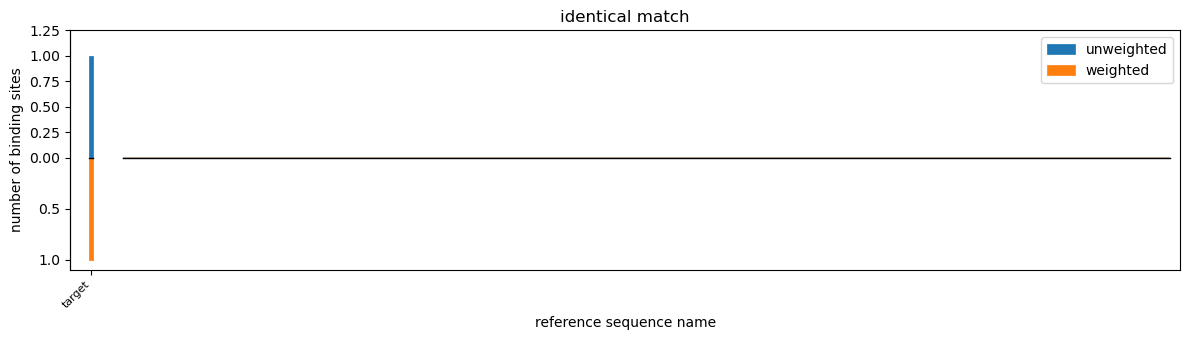

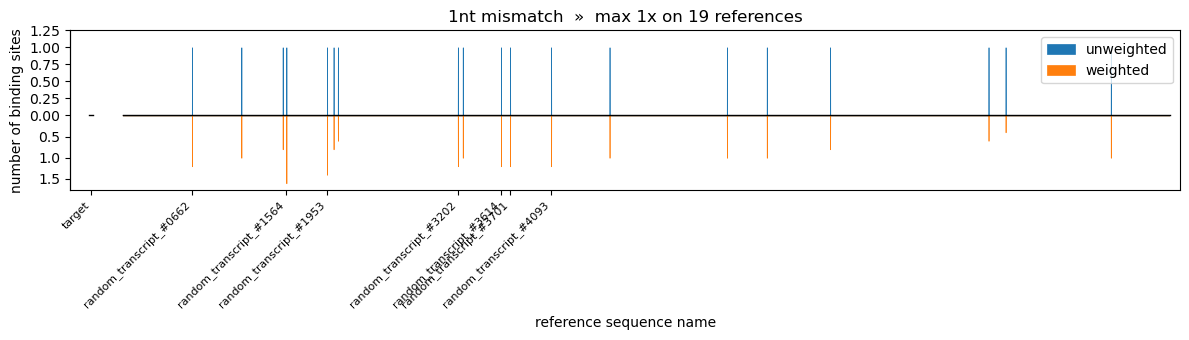

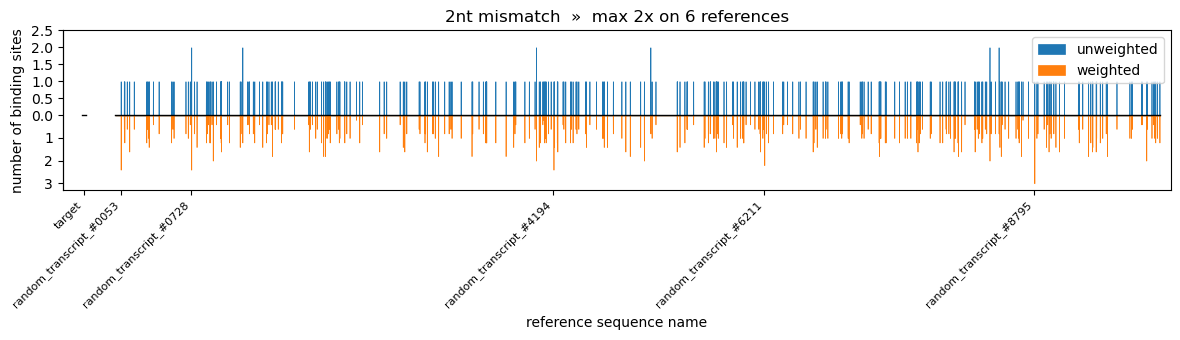

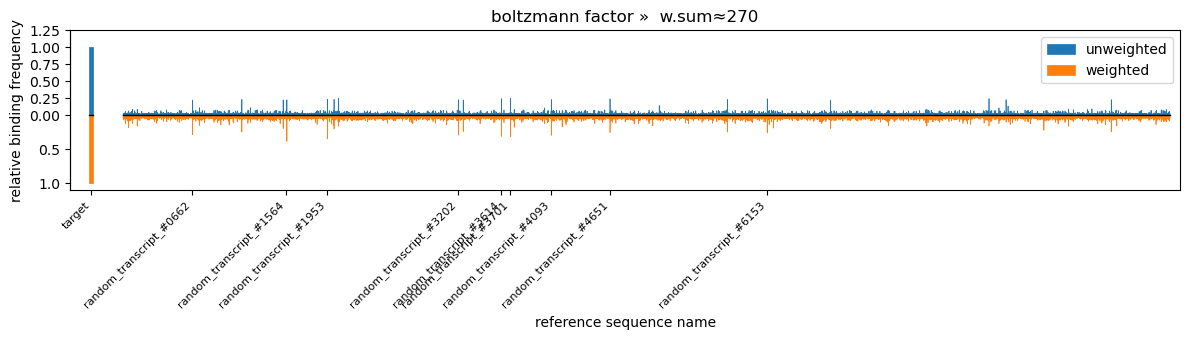


----------------------------------------------------------------------------------------------------
SEQUENCE                                                           GCCCCAATTGAA
SEQ_NAME                                                random_transcript_#9999
identical match max                                                         0.0
identical match sum                                                         0.0
identical match VIR                                                          []
identical match W.max                                                       0.0
identical match W.sum                                                       0.0
identical match W.VIR                                                        []
1nt mismatch max                                                            1.0
1nt mismatch sum                                                           16.0
1nt mismatch VIR              [random_transcript_#0070, random_transcript_#0...
1nt mismatch W.max

C:\Users\T3D\AppData\Local\Temp\ipykernel_12056\3604443692.py:24: UserWarning: Warning, deprecated input type for query: string. Please use pandas.Series!
  warnings.warn("Warning, deprecated input type for query: string. Please use pandas.Series!")


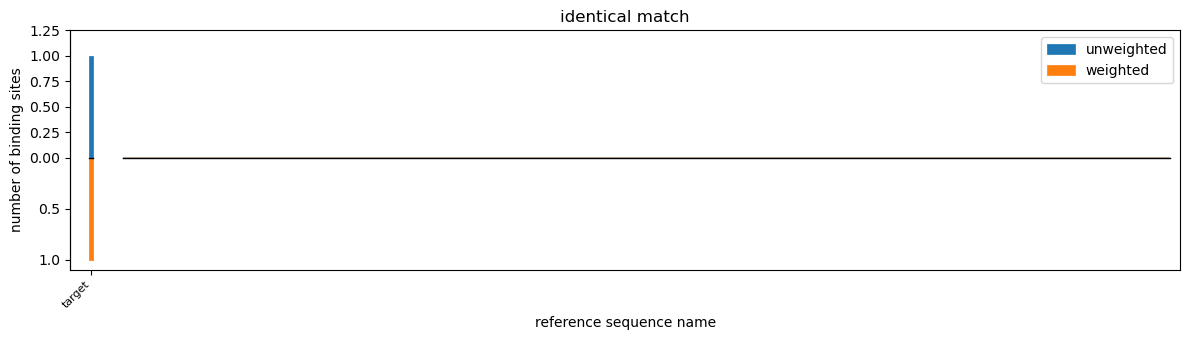

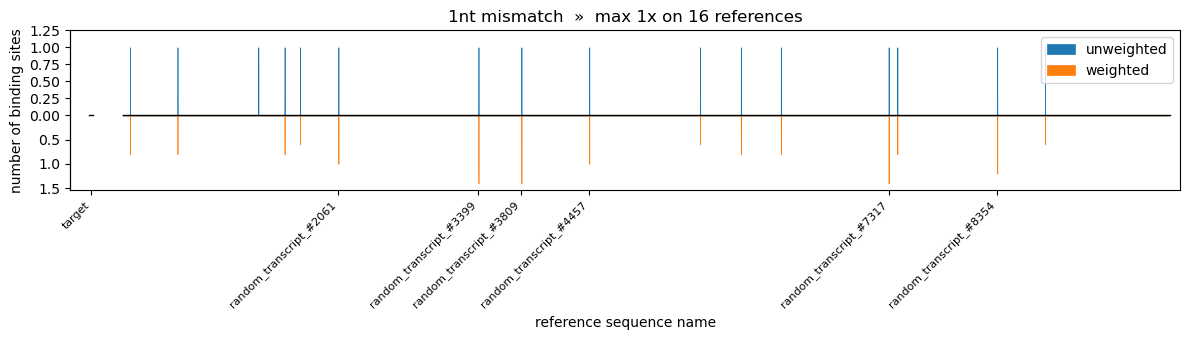

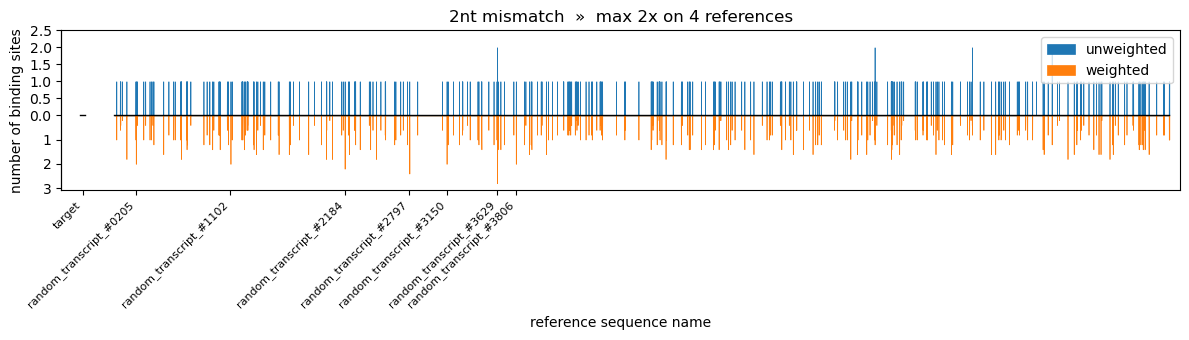

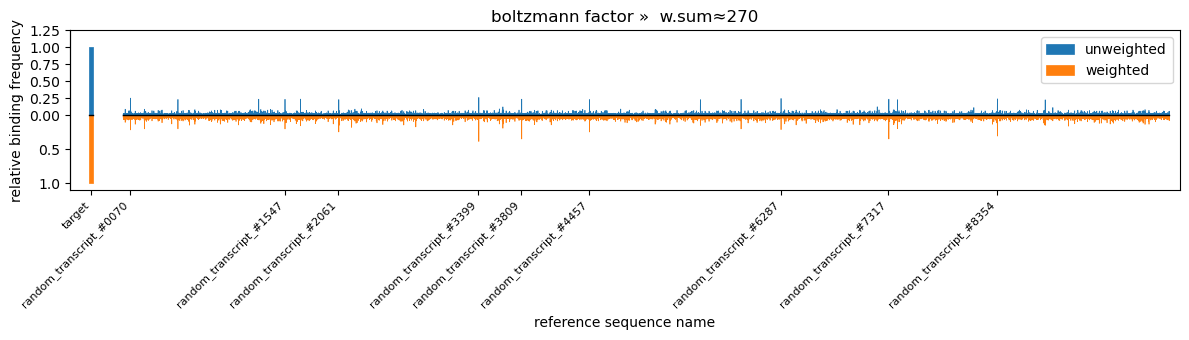


----------------------------------------------------------------------------------------------------
SEQUENCE                                                           ACGGCCGCTGGA
SEQ_NAME                                                random_transcript_#9999
identical match max                                                         0.0
identical match sum                                                         0.0
identical match VIR                                                          []
identical match W.max                                                       0.0
identical match W.sum                                                       0.0
identical match W.VIR                                                        []
1nt mismatch max                                                            1.0
1nt mismatch sum                                                           21.0
1nt mismatch VIR              [random_transcript_#0020, random_transcript_#0...
1nt mismatch W.max

C:\Users\T3D\AppData\Local\Temp\ipykernel_12056\3604443692.py:24: UserWarning: Warning, deprecated input type for query: string. Please use pandas.Series!
  warnings.warn("Warning, deprecated input type for query: string. Please use pandas.Series!")


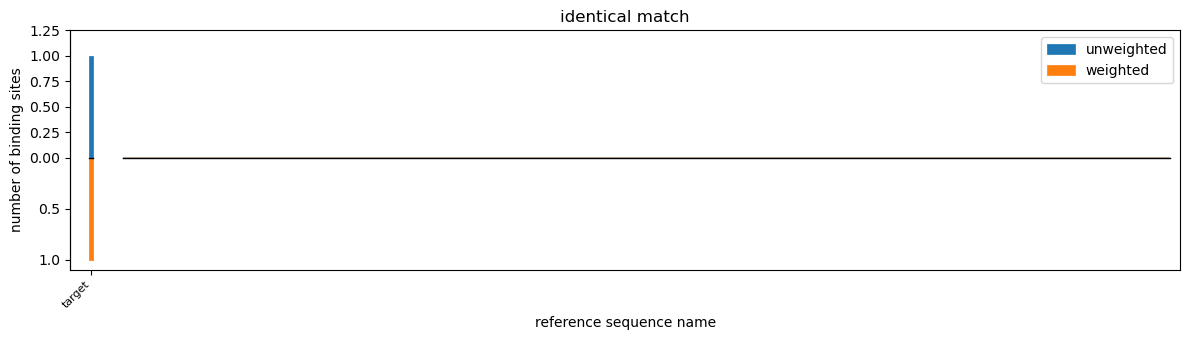

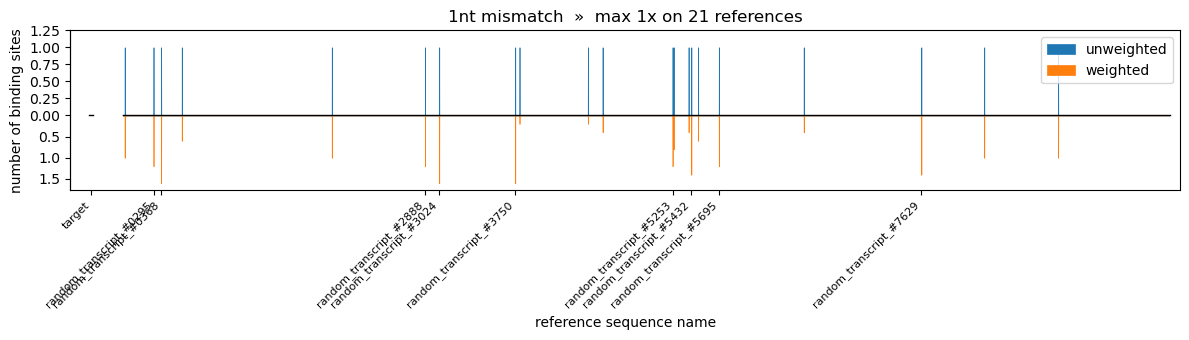

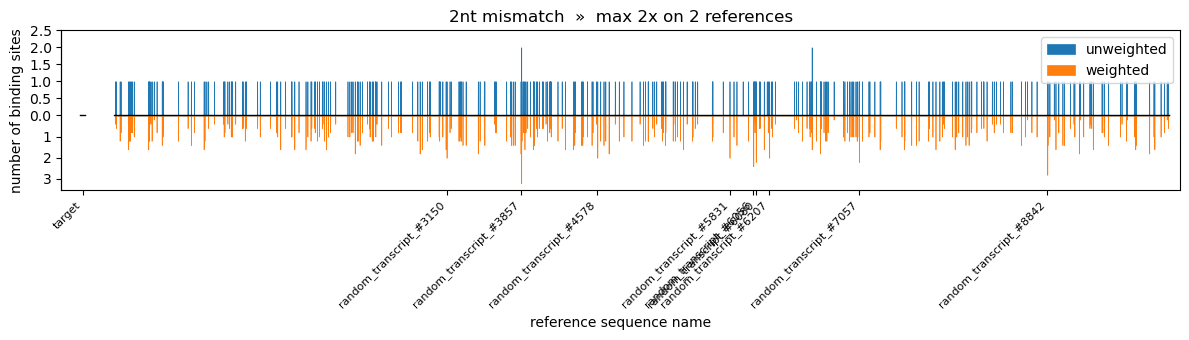

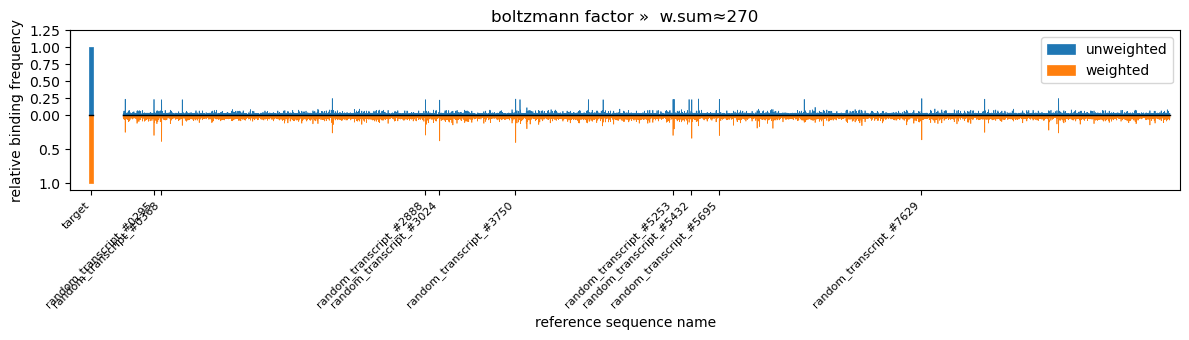


----------------------------------------------------------------------------------------------------
SEQUENCE                                                           ACGGATATGCTA
SEQ_NAME                                                random_transcript_#9999
identical match max                                                         0.0
identical match sum                                                         0.0
identical match VIR                                                          []
identical match W.max                                                       0.0
identical match W.sum                                                       0.0
identical match W.VIR                                                        []
1nt mismatch max                                                            1.0
1nt mismatch sum                                                           18.0
1nt mismatch VIR              [random_transcript_#0317, random_transcript_#0...
1nt mismatch W.max

C:\Users\T3D\AppData\Local\Temp\ipykernel_12056\3604443692.py:24: UserWarning: Warning, deprecated input type for query: string. Please use pandas.Series!
  warnings.warn("Warning, deprecated input type for query: string. Please use pandas.Series!")


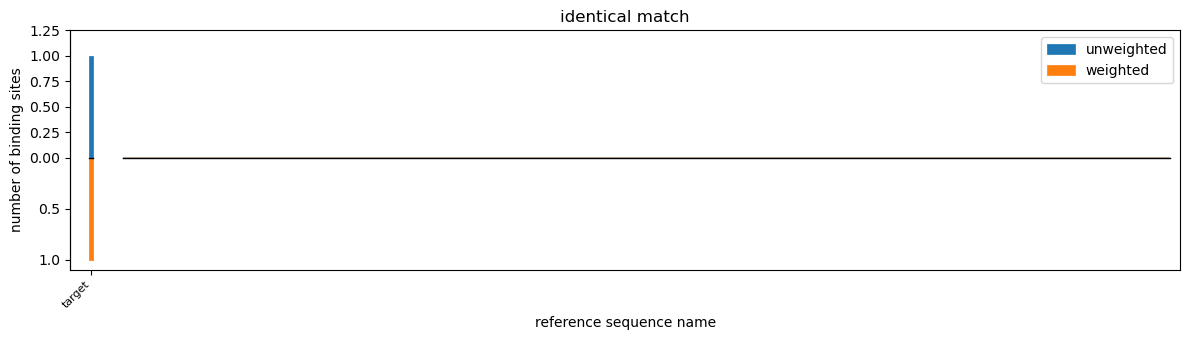

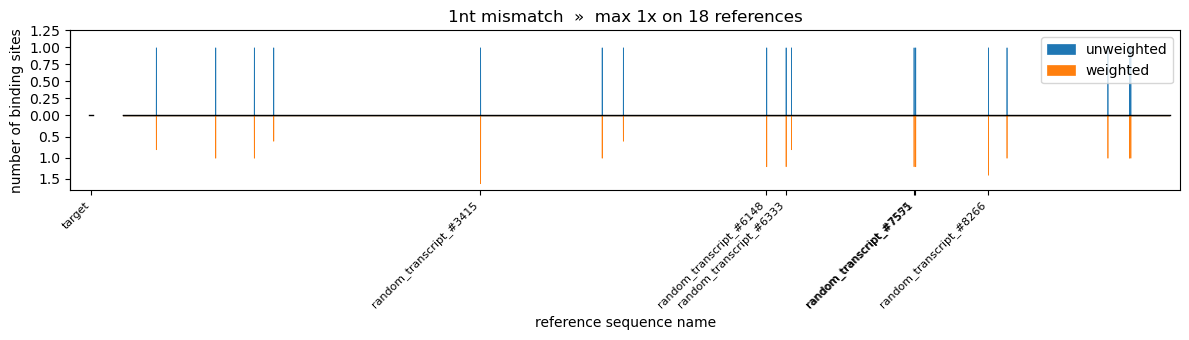

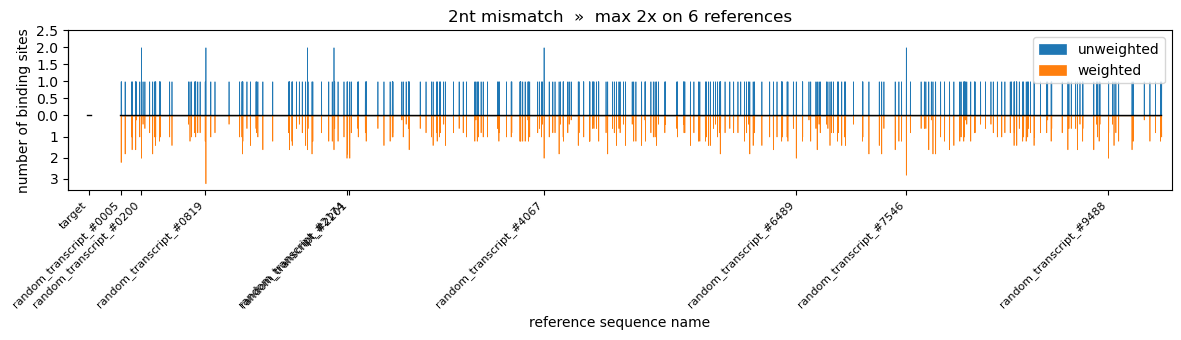

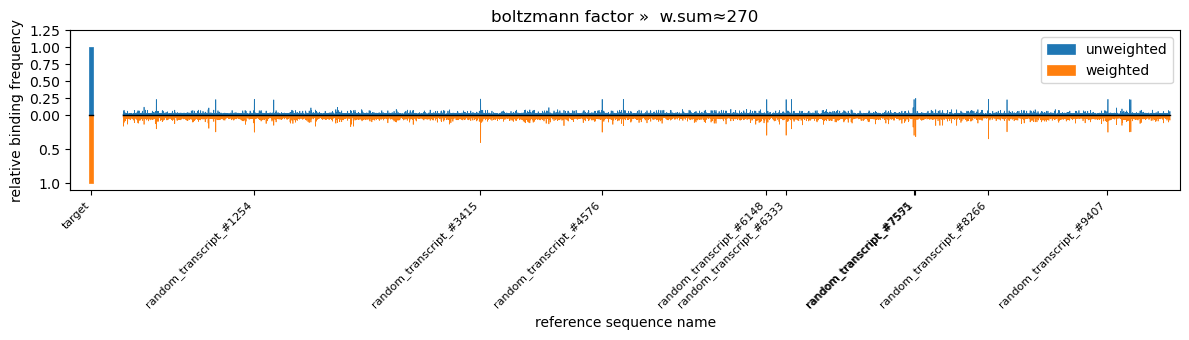


----------------------------------------------------------------------------------------------------
SEQUENCE                                                           CGCCCCAATTGA
SEQ_NAME                                                random_transcript_#9999
identical match max                                                         0.0
identical match sum                                                         0.0
identical match VIR                                                          []
identical match W.max                                                       0.0
identical match W.sum                                                       0.0
identical match W.VIR                                                        []
1nt mismatch max                                                            1.0
1nt mismatch sum                                                           18.0
1nt mismatch VIR              [random_transcript_#0524, random_transcript_#0...
1nt mismatch W.max

C:\Users\T3D\AppData\Local\Temp\ipykernel_12056\3604443692.py:24: UserWarning: Warning, deprecated input type for query: string. Please use pandas.Series!
  warnings.warn("Warning, deprecated input type for query: string. Please use pandas.Series!")


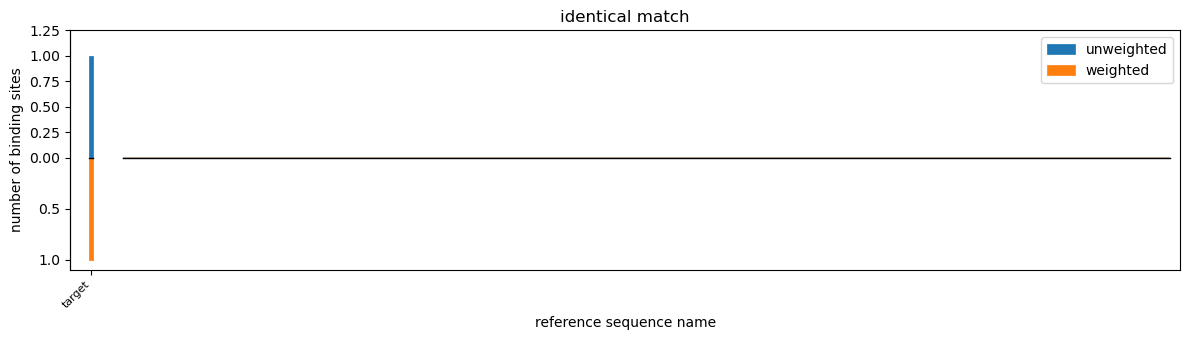

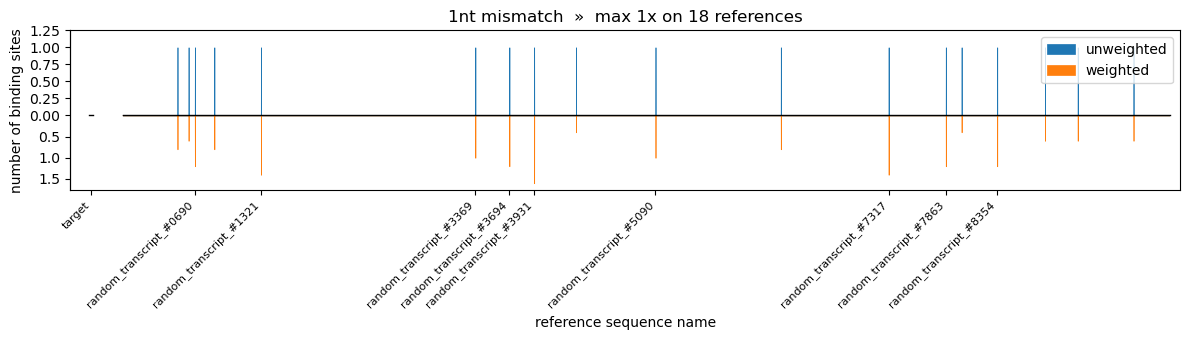

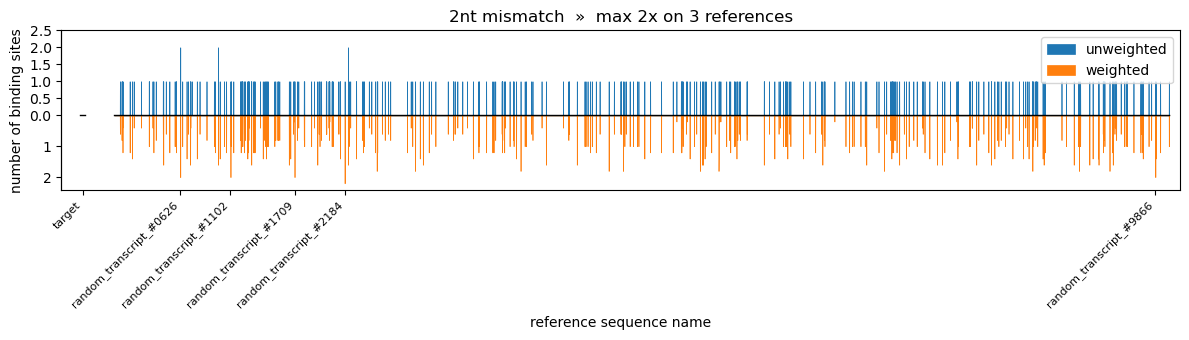

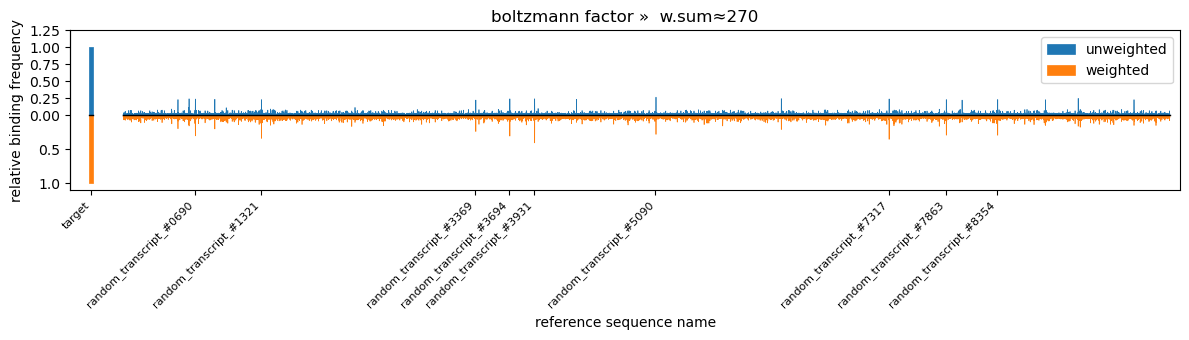


----------------------------------------------------------------------------------------------------
SEQUENCE                                                           CTTGCACTAATT
SEQ_NAME                                                random_transcript_#9999
identical match max                                                         0.0
identical match sum                                                         0.0
identical match VIR                                                          []
identical match W.max                                                       0.0
identical match W.sum                                                       0.0
identical match W.VIR                                                        []
1nt mismatch max                                                            1.0
1nt mismatch sum                                                           19.0
1nt mismatch VIR              [random_transcript_#0504, random_transcript_#1...
1nt mismatch W.max

C:\Users\T3D\AppData\Local\Temp\ipykernel_12056\3604443692.py:24: UserWarning: Warning, deprecated input type for query: string. Please use pandas.Series!
  warnings.warn("Warning, deprecated input type for query: string. Please use pandas.Series!")


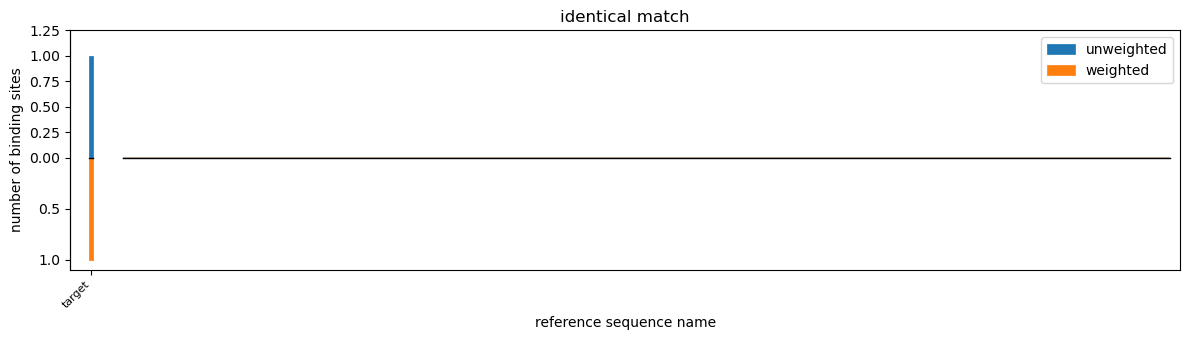

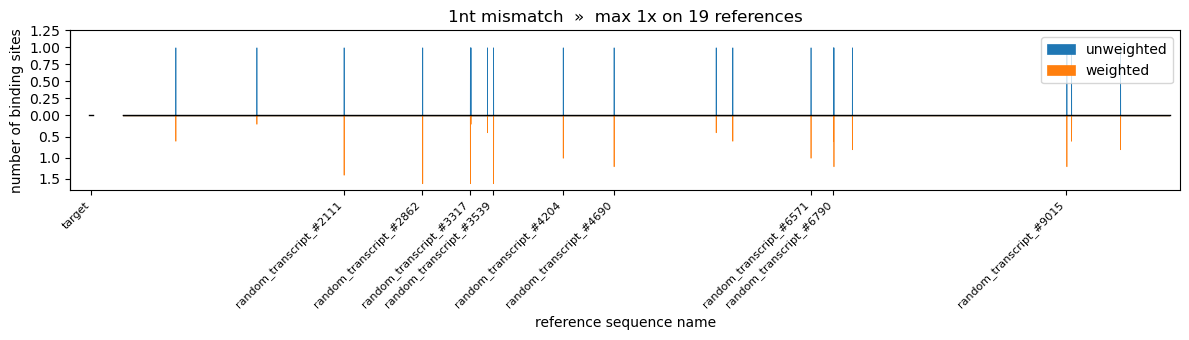

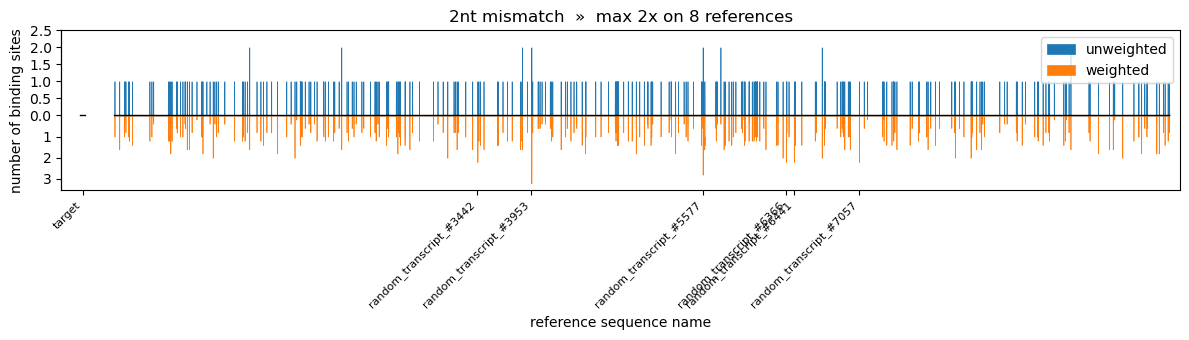

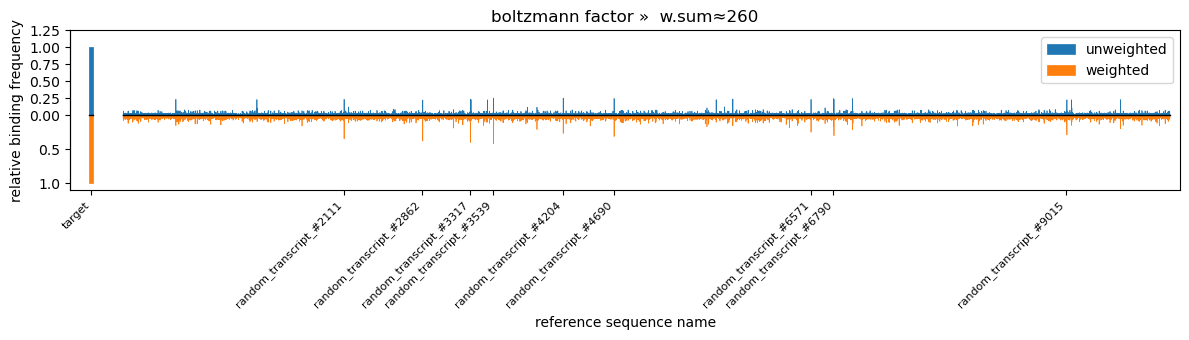


----------------------------------------------------------------------------------------------------
SEQUENCE                                                           GCACATCCAAGT
SEQ_NAME                                                random_transcript_#9999
identical match max                                                         0.0
identical match sum                                                         0.0
identical match VIR                                                          []
identical match W.max                                                       0.0
identical match W.sum                                                       0.0
identical match W.VIR                                                        []
1nt mismatch max                                                            1.0
1nt mismatch sum                                                           18.0
1nt mismatch VIR              [random_transcript_#0121, random_transcript_#0...
1nt mismatch W.max

C:\Users\T3D\AppData\Local\Temp\ipykernel_12056\3604443692.py:24: UserWarning: Warning, deprecated input type for query: string. Please use pandas.Series!
  warnings.warn("Warning, deprecated input type for query: string. Please use pandas.Series!")


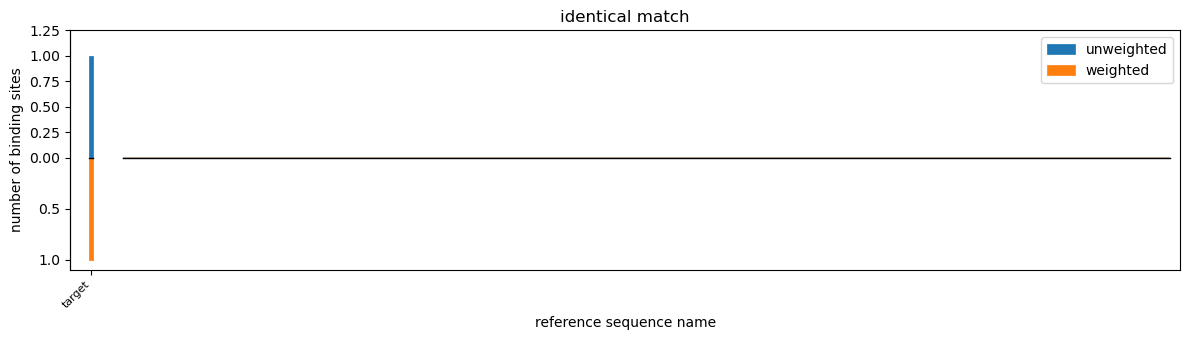

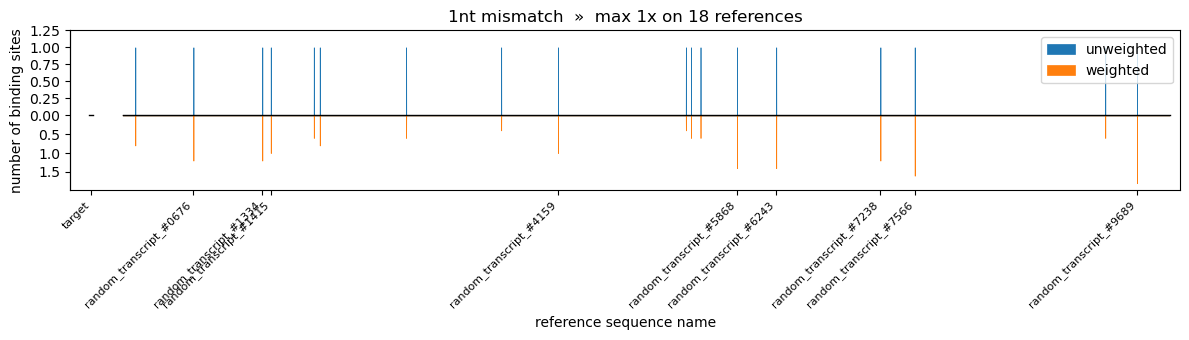

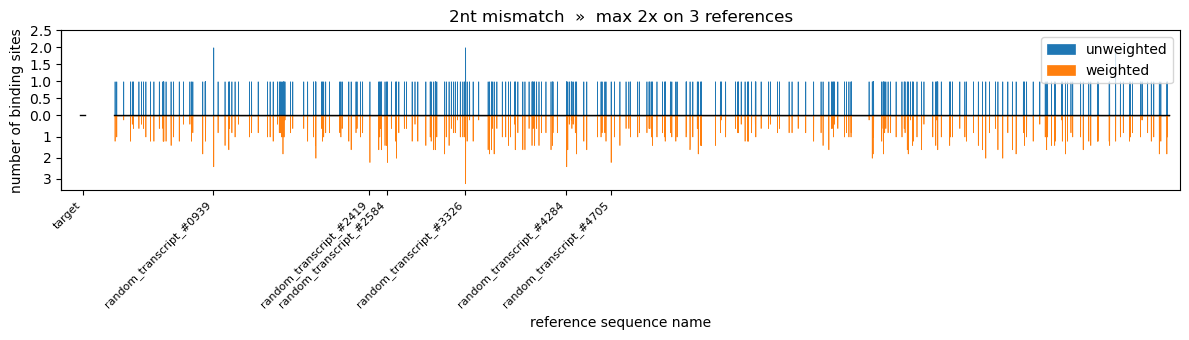

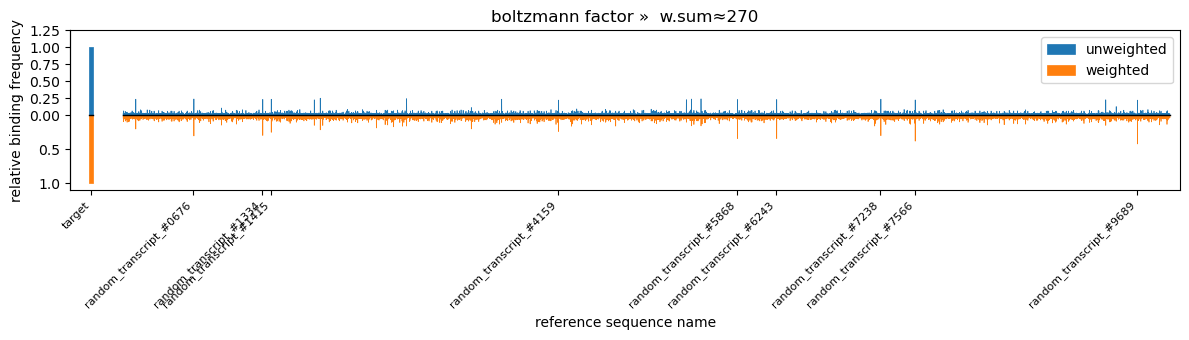


----------------------------------------------------------------------------------------------------
SEQUENCE                                                           TCGAATTGGATT
SEQ_NAME                                                random_transcript_#9999
identical match max                                                         0.0
identical match sum                                                         0.0
identical match VIR                                                          []
identical match W.max                                                       0.0
identical match W.sum                                                       0.0
identical match W.VIR                                                        []
1nt mismatch max                                                            1.0
1nt mismatch sum                                                           19.0
1nt mismatch VIR              [random_transcript_#0391, random_transcript_#0...
1nt mismatch W.max

C:\Users\T3D\AppData\Local\Temp\ipykernel_12056\3604443692.py:24: UserWarning: Warning, deprecated input type for query: string. Please use pandas.Series!
  warnings.warn("Warning, deprecated input type for query: string. Please use pandas.Series!")


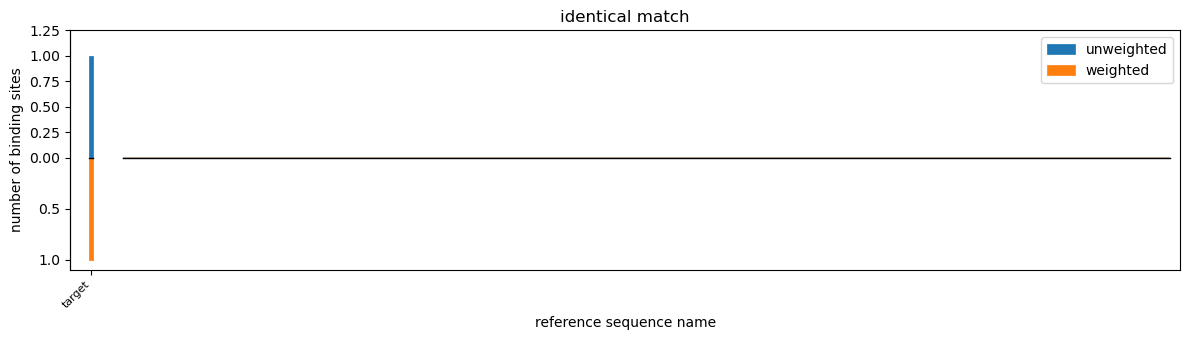

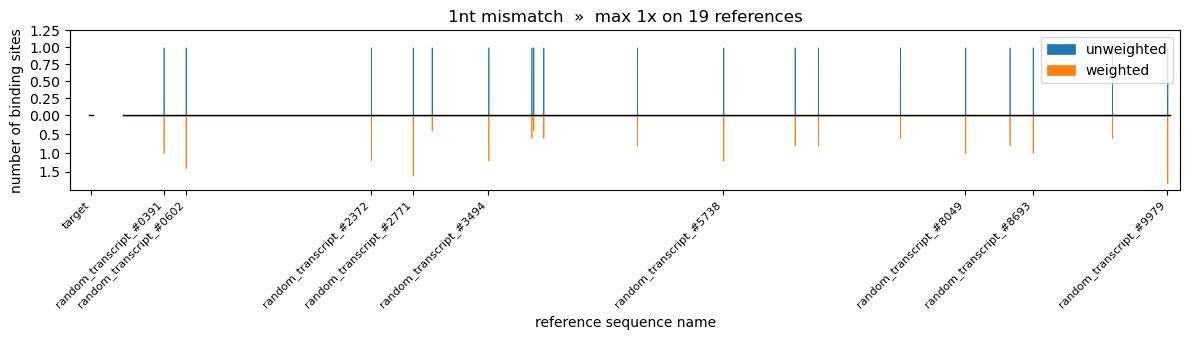

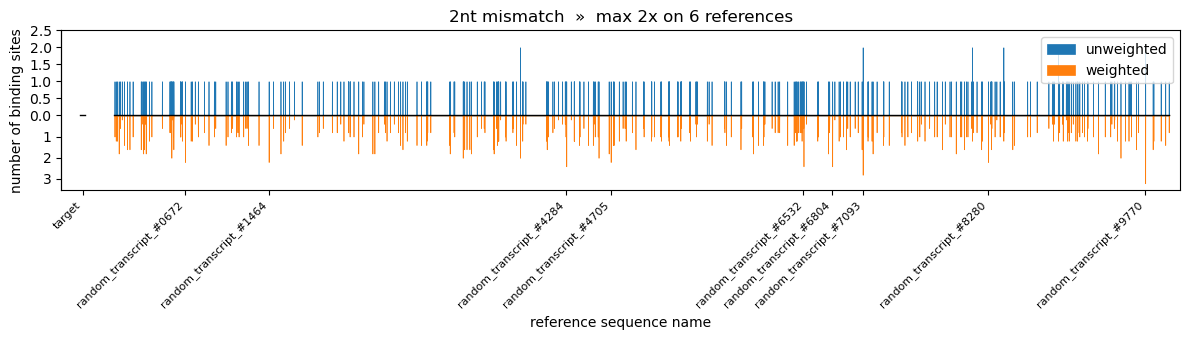

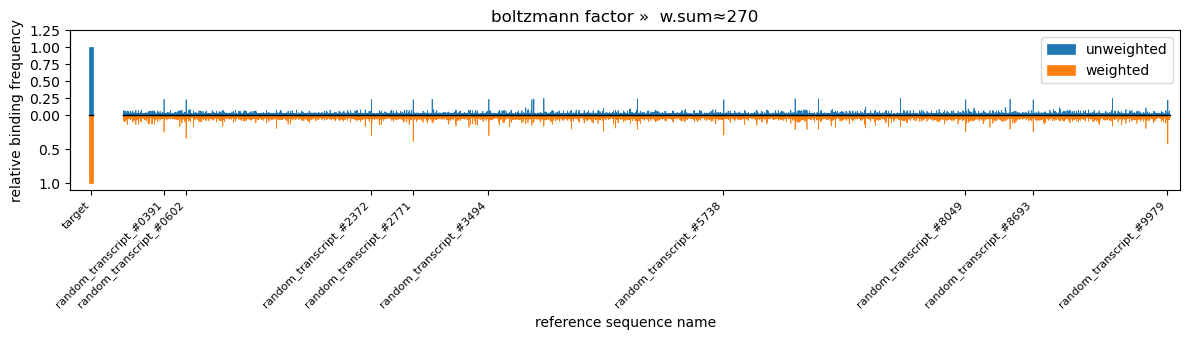


----------------------------------------------------------------------------------------------------
SEQUENCE                                                           CACTCCCCATGT
SEQ_NAME                                                random_transcript_#9999
identical match max                                                         0.0
identical match sum                                                         0.0
identical match VIR                                                          []
identical match W.max                                                       0.0
identical match W.sum                                                       0.0
identical match W.VIR                                                        []
1nt mismatch max                                                            1.0
1nt mismatch sum                                                           18.0
1nt mismatch VIR              [random_transcript_#0586, random_transcript_#0...
1nt mismatch W.max

C:\Users\T3D\AppData\Local\Temp\ipykernel_12056\3604443692.py:24: UserWarning: Warning, deprecated input type for query: string. Please use pandas.Series!
  warnings.warn("Warning, deprecated input type for query: string. Please use pandas.Series!")


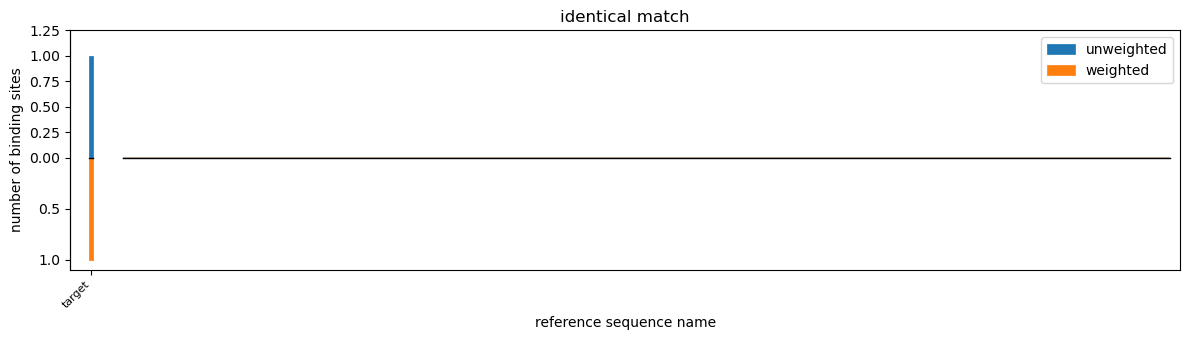

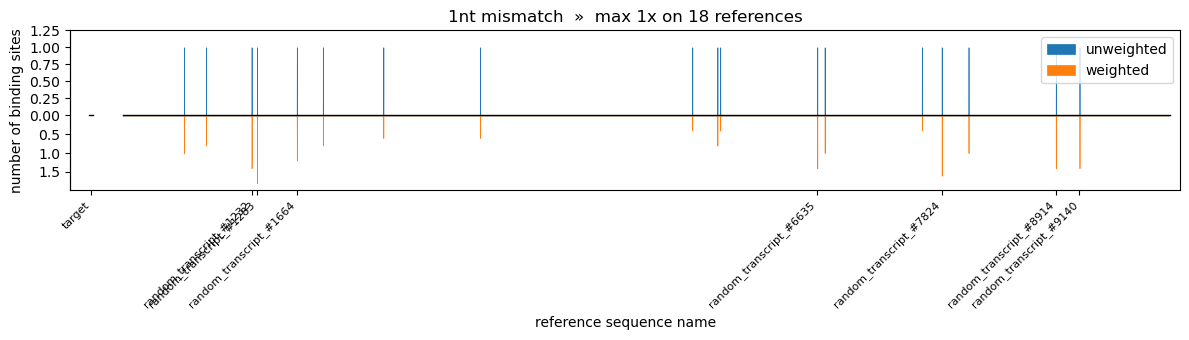

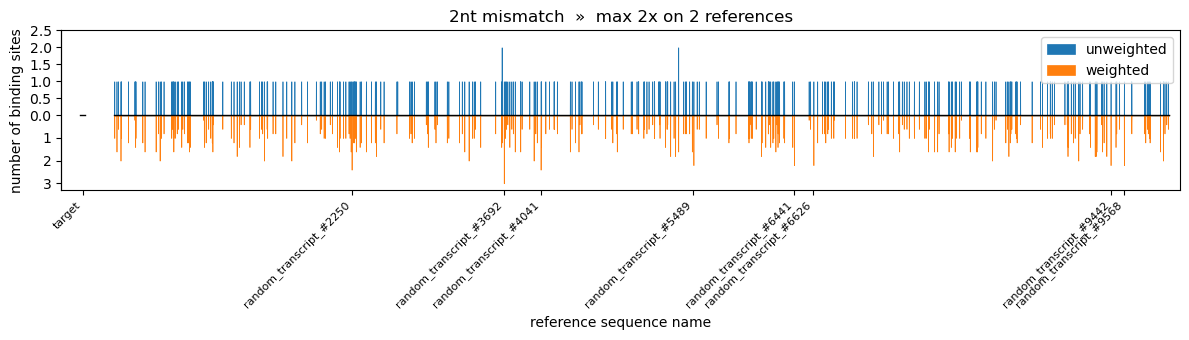

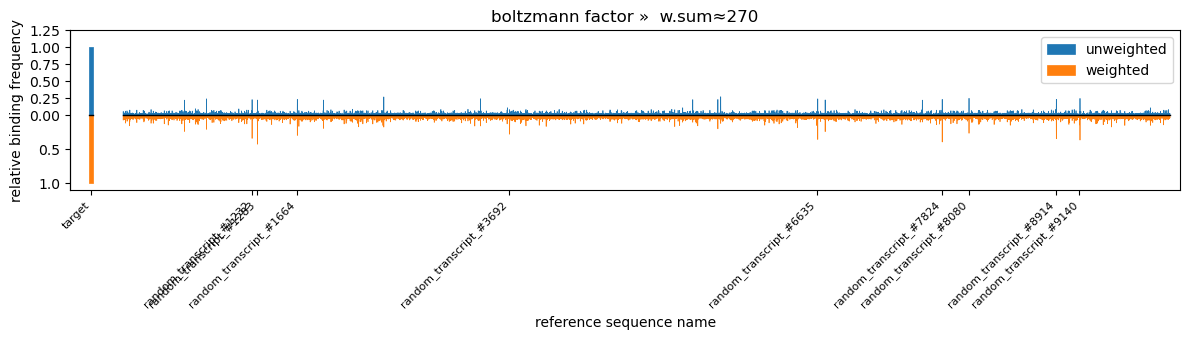


----------------------------------------------------------------------------------------------------
SEQUENCE                                                           CCCGGTTCATGA
SEQ_NAME                                                random_transcript_#9999
identical match max                                                         0.0
identical match sum                                                         0.0
identical match VIR                                                          []
identical match W.max                                                       0.0
identical match W.sum                                                       0.0
identical match W.VIR                                                        []
1nt mismatch max                                                            1.0
1nt mismatch sum                                                           17.0
1nt mismatch VIR              [random_transcript_#0046, random_transcript_#1...
1nt mismatch W.max

C:\Users\T3D\AppData\Local\Temp\ipykernel_12056\3604443692.py:24: UserWarning: Warning, deprecated input type for query: string. Please use pandas.Series!
  warnings.warn("Warning, deprecated input type for query: string. Please use pandas.Series!")


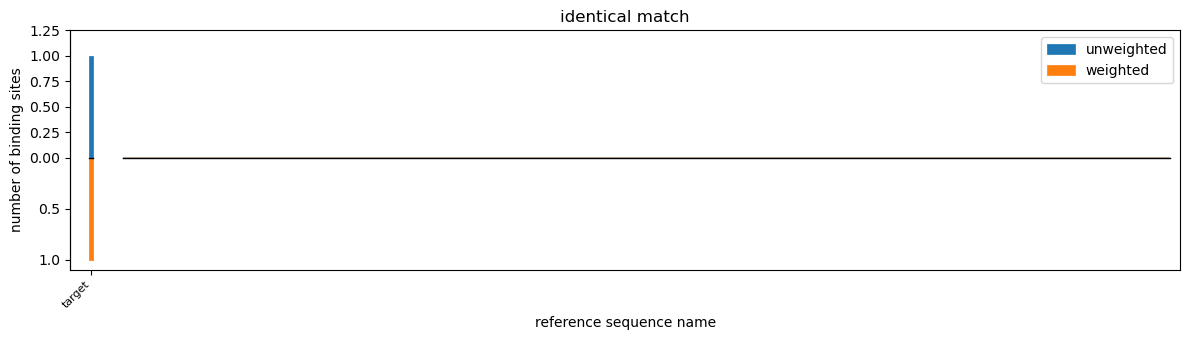

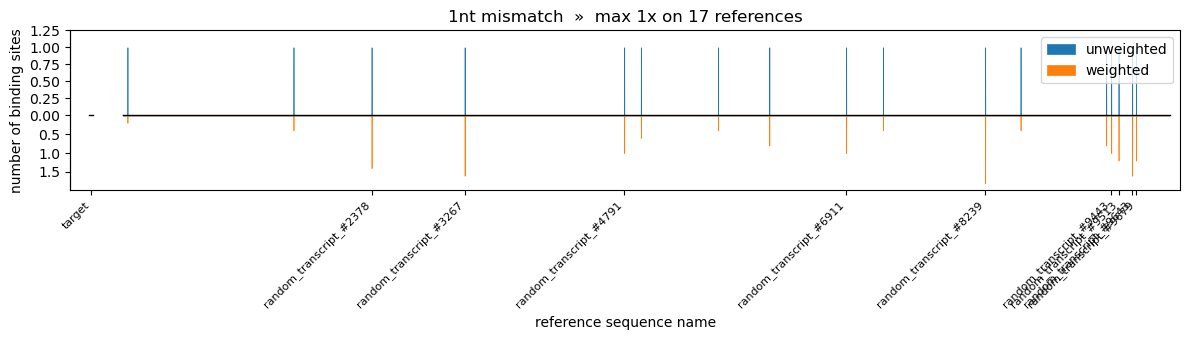

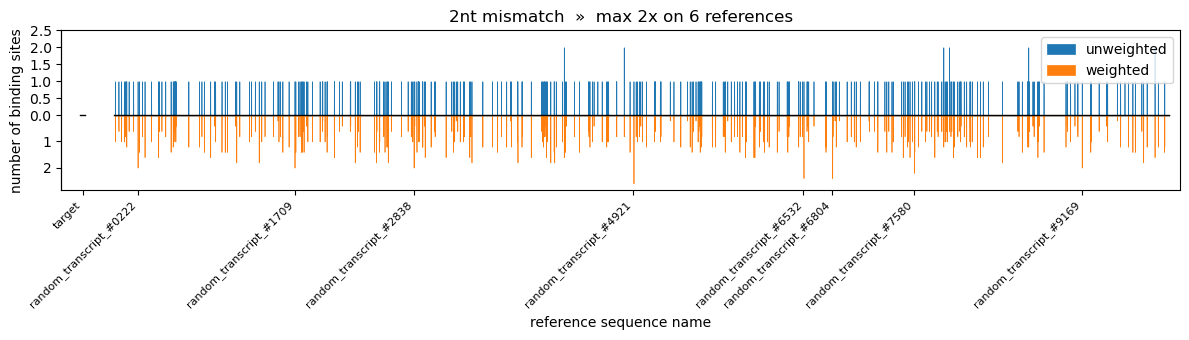

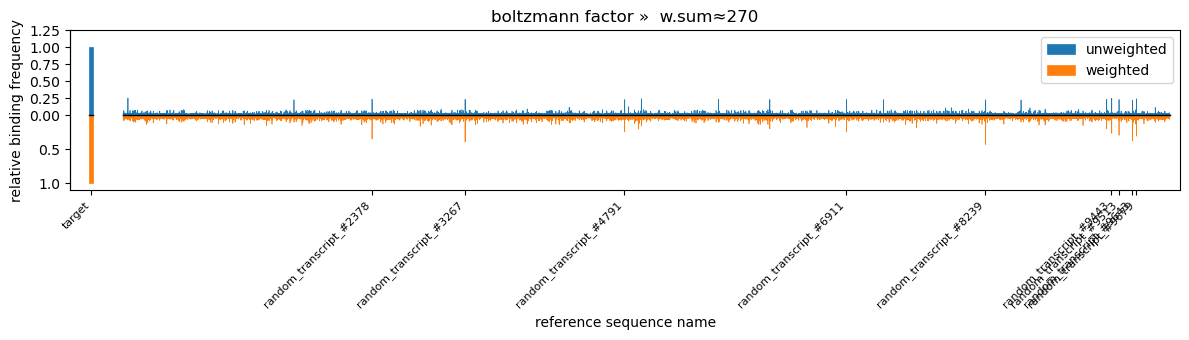


----------------------------------------------------------------------------------------------------
SEQUENCE                                                           GGATATGCTACT
SEQ_NAME                                                random_transcript_#9999
identical match max                                                         0.0
identical match sum                                                         0.0
identical match VIR                                                          []
identical match W.max                                                       0.0
identical match W.sum                                                       0.0
identical match W.VIR                                                        []
1nt mismatch max                                                            1.0
1nt mismatch sum                                                           17.0
1nt mismatch VIR              [random_transcript_#0317, random_transcript_#0...
1nt mismatch W.max

C:\Users\T3D\AppData\Local\Temp\ipykernel_12056\3604443692.py:24: UserWarning: Warning, deprecated input type for query: string. Please use pandas.Series!
  warnings.warn("Warning, deprecated input type for query: string. Please use pandas.Series!")


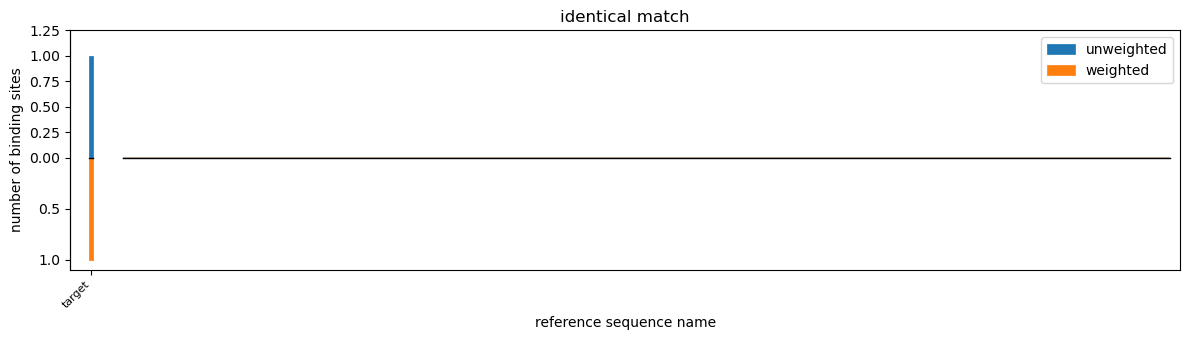

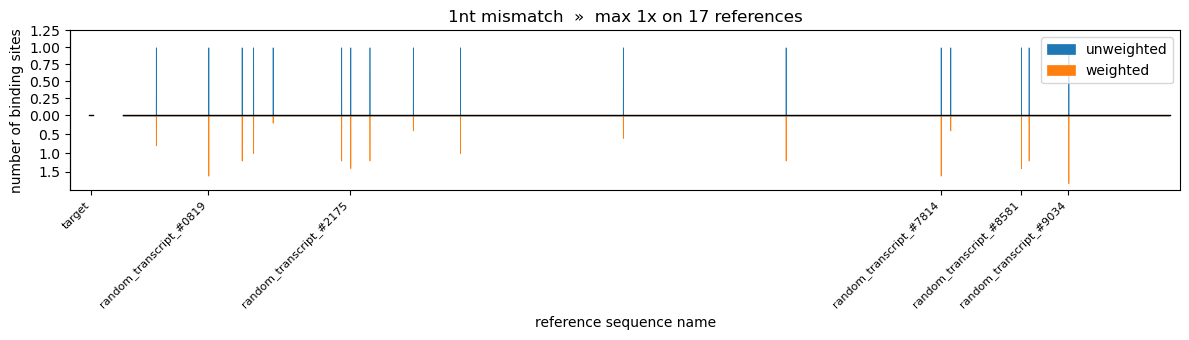

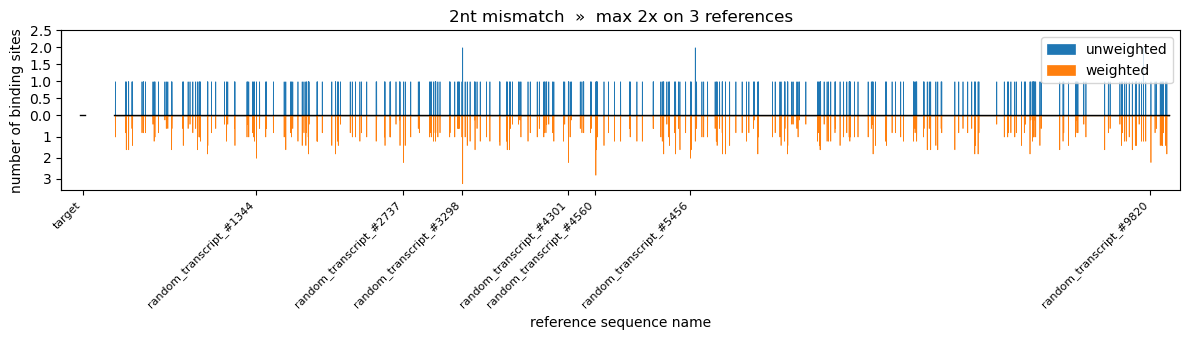

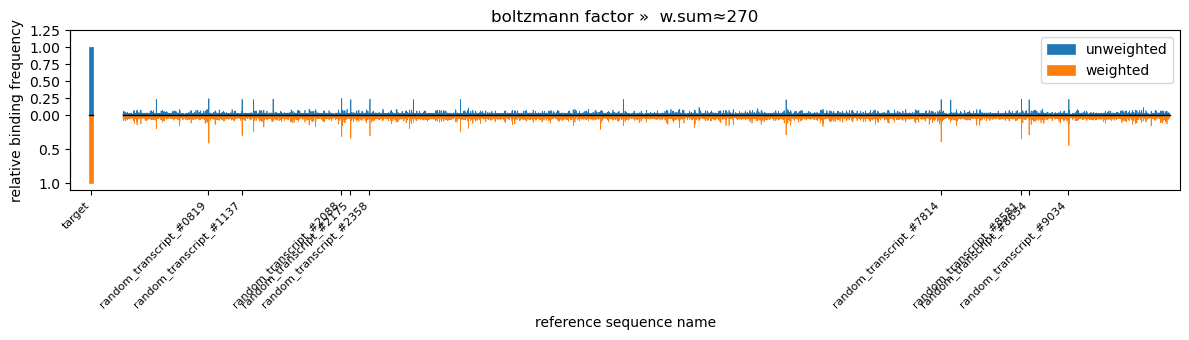


----------------------------------------------------------------------------------------------------
SEQUENCE                                                           GCCCAATGACTC
SEQ_NAME                                                random_transcript_#9999
identical match max                                                         0.0
identical match sum                                                         0.0
identical match VIR                                                          []
identical match W.max                                                       0.0
identical match W.sum                                                       0.0
identical match W.VIR                                                        []
1nt mismatch max                                                            1.0
1nt mismatch sum                                                           19.0
1nt mismatch VIR              [random_transcript_#0829, random_transcript_#1...
1nt mismatch W.max

C:\Users\T3D\AppData\Local\Temp\ipykernel_12056\3604443692.py:24: UserWarning: Warning, deprecated input type for query: string. Please use pandas.Series!
  warnings.warn("Warning, deprecated input type for query: string. Please use pandas.Series!")


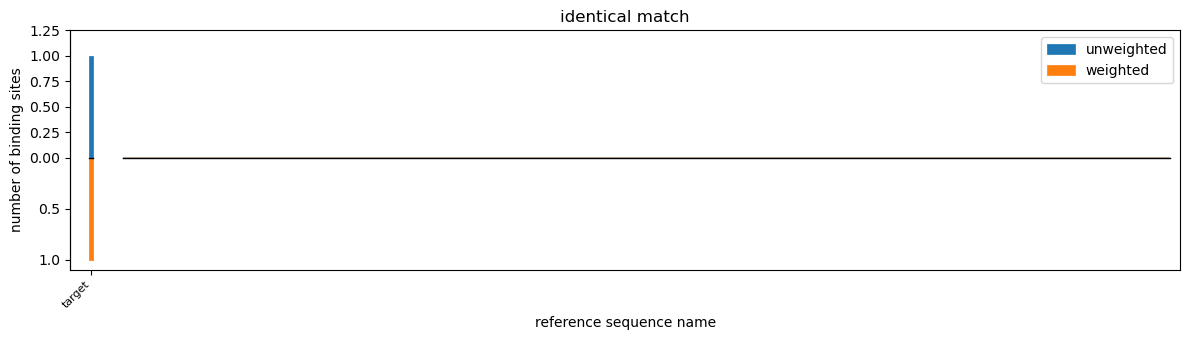

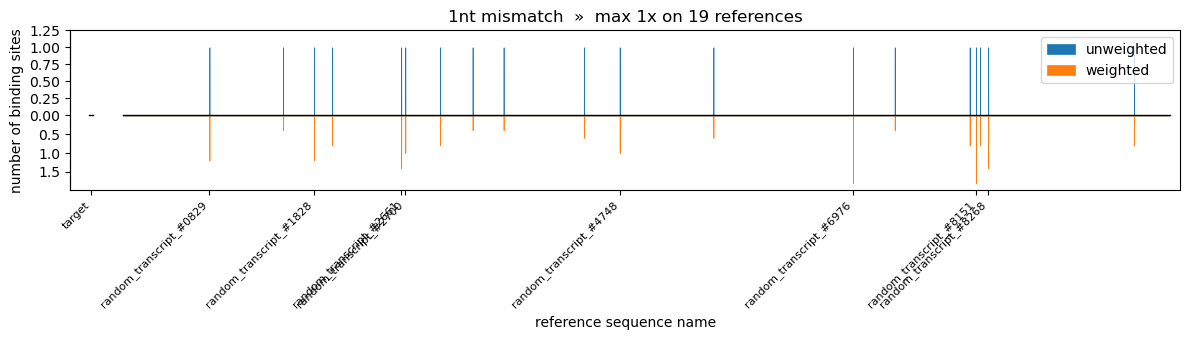

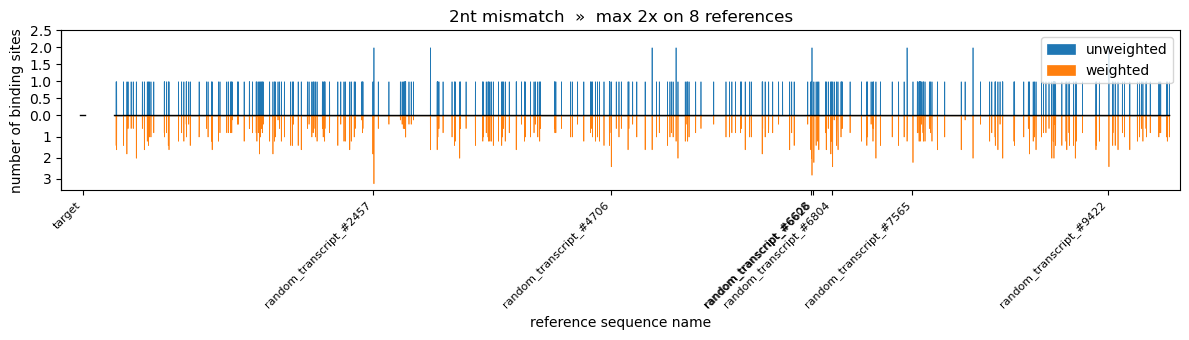

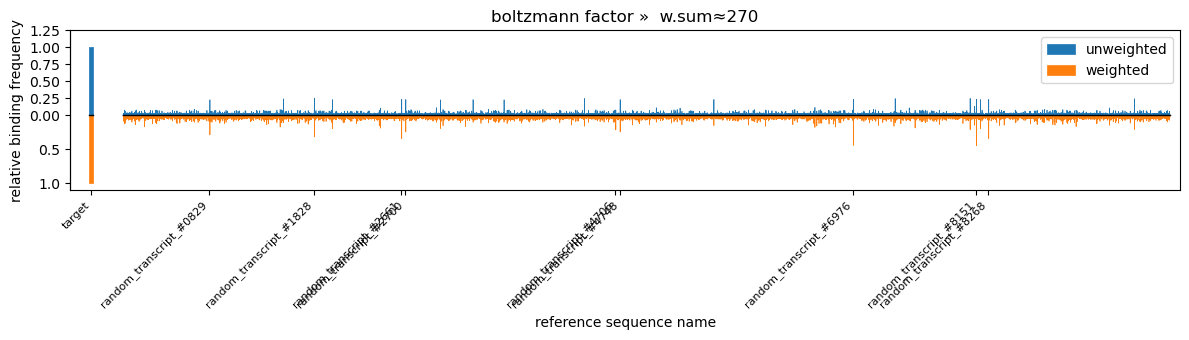


----------------------------------------------------------------------------------------------------
SEQUENCE                                                           GATATGCTACTC
SEQ_NAME                                                random_transcript_#9999
identical match max                                                         0.0
identical match sum                                                         0.0
identical match VIR                                                          []
identical match W.max                                                       0.0
identical match W.sum                                                       0.0
identical match W.VIR                                                        []
1nt mismatch max                                                            1.0
1nt mismatch sum                                                           18.0
1nt mismatch VIR              [random_transcript_#0646, random_transcript_#0...
1nt mismatch W.max

C:\Users\T3D\AppData\Local\Temp\ipykernel_12056\3604443692.py:24: UserWarning: Warning, deprecated input type for query: string. Please use pandas.Series!
  warnings.warn("Warning, deprecated input type for query: string. Please use pandas.Series!")


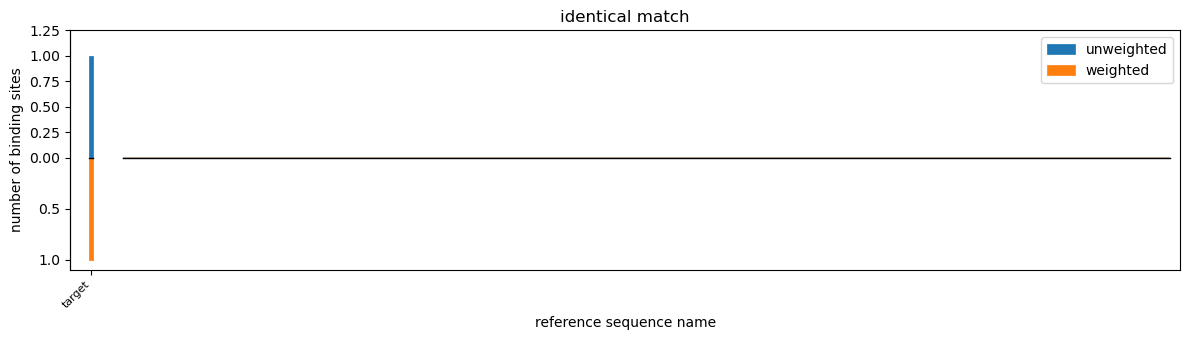

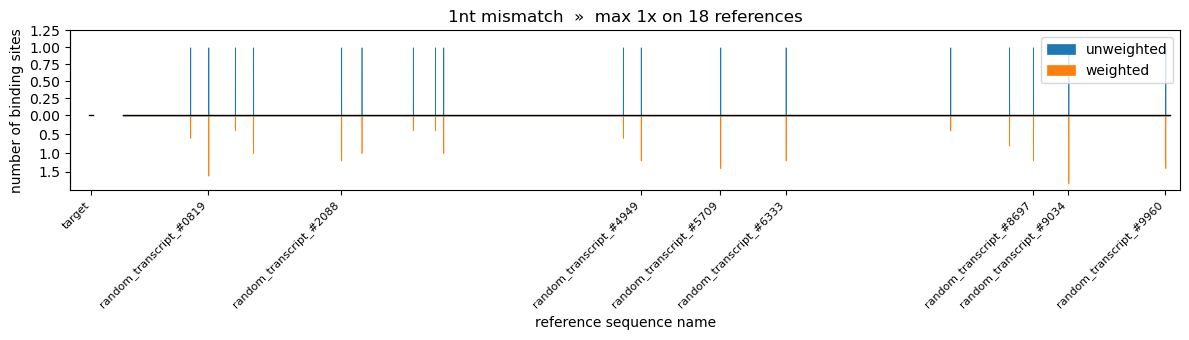

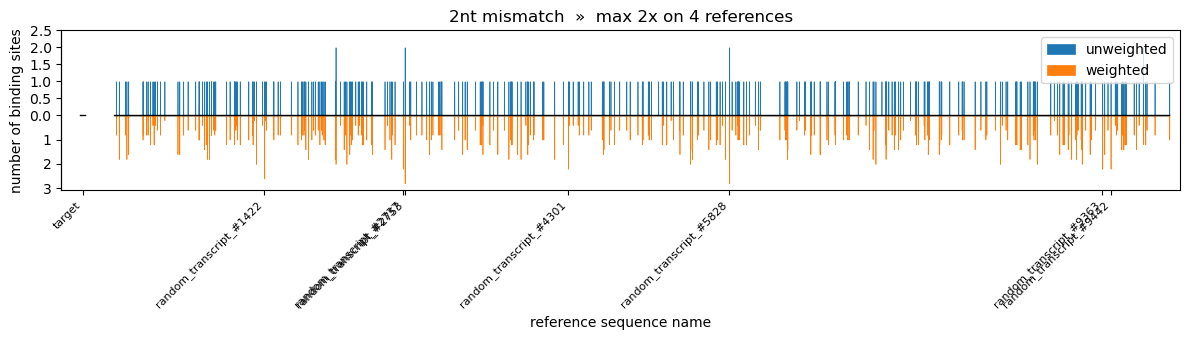

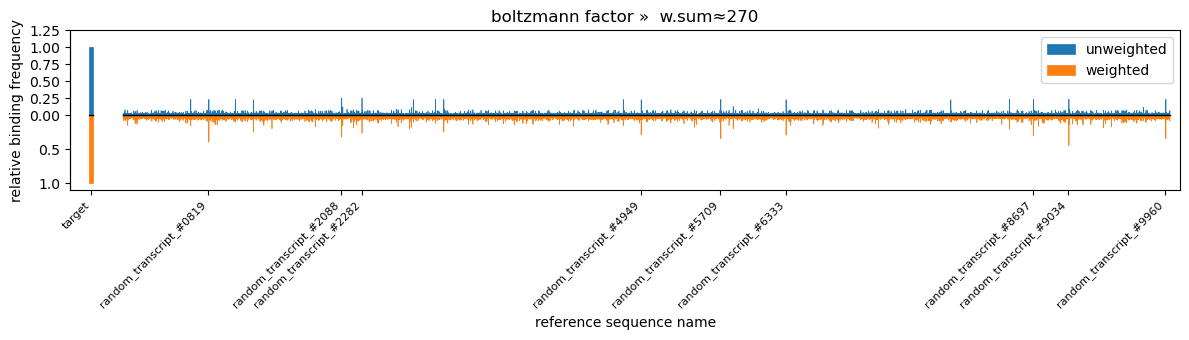


----------------------------------------------------------------------------------------------------
SEQUENCE                                                           GGCCATATACCC
SEQ_NAME                                                random_transcript_#9999
identical match max                                                         0.0
identical match sum                                                         0.0
identical match VIR                                                          []
identical match W.max                                                       0.0
identical match W.sum                                                       0.0
identical match W.VIR                                                        []
1nt mismatch max                                                            1.0
1nt mismatch sum                                                           19.0
1nt mismatch VIR              [random_transcript_#1342, random_transcript_#2...
1nt mismatch W.max

C:\Users\T3D\AppData\Local\Temp\ipykernel_12056\3604443692.py:24: UserWarning: Warning, deprecated input type for query: string. Please use pandas.Series!
  warnings.warn("Warning, deprecated input type for query: string. Please use pandas.Series!")


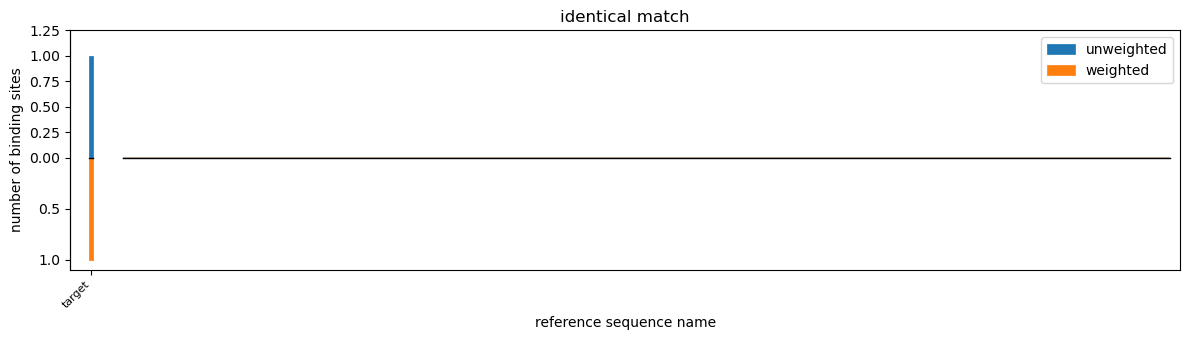

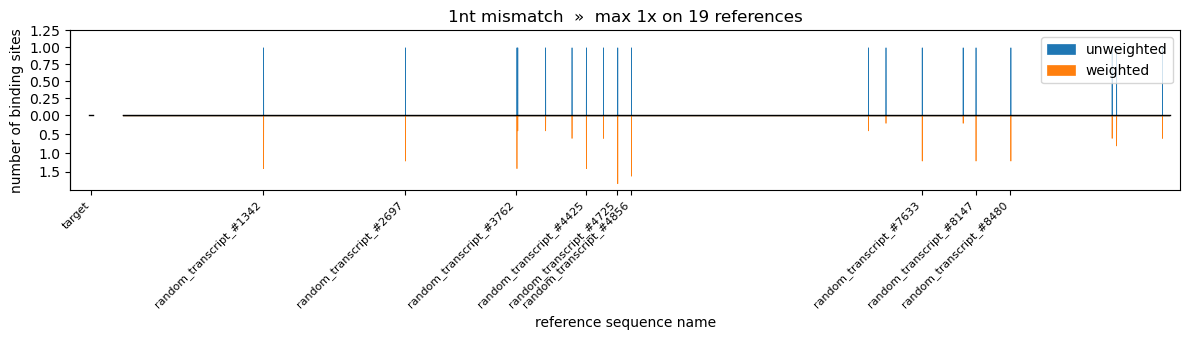

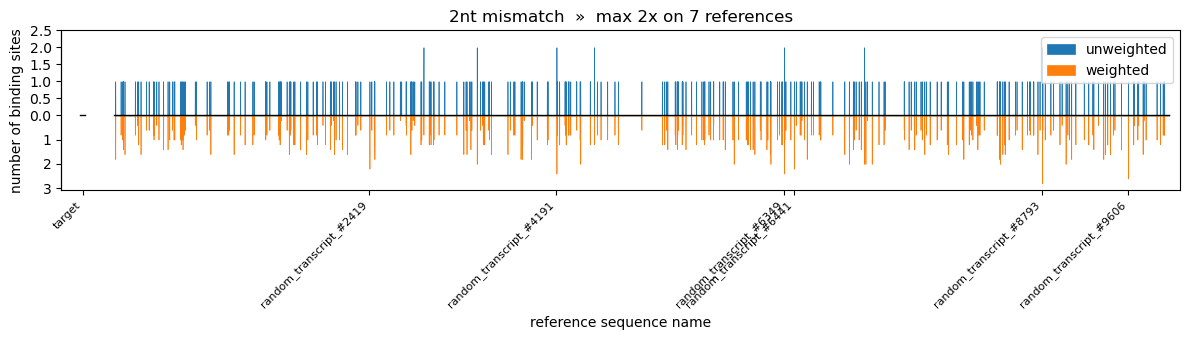

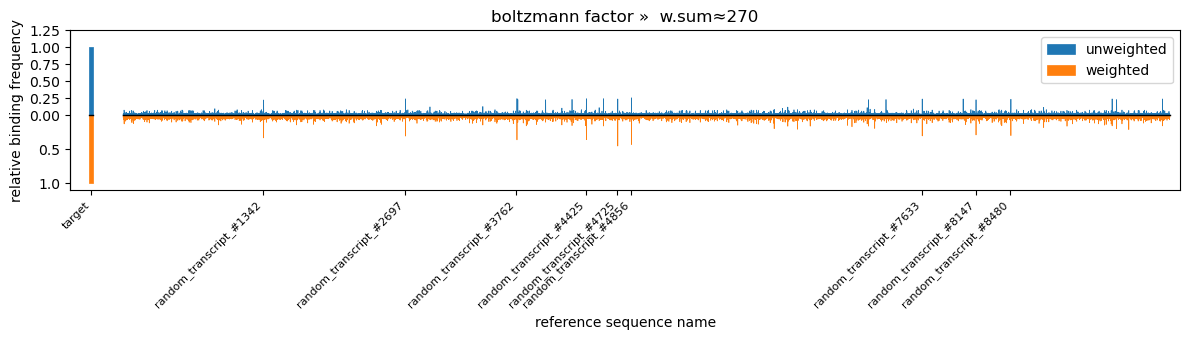


----------------------------------------------------------------------------------------------------
SEQUENCE                                                           ATGACTCACGGA
SEQ_NAME                                                random_transcript_#9999
identical match max                                                         0.0
identical match sum                                                         0.0
identical match VIR                                                          []
identical match W.max                                                       0.0
identical match W.sum                                                       0.0
identical match W.VIR                                                        []
1nt mismatch max                                                            1.0
1nt mismatch sum                                                           19.0
1nt mismatch VIR              [random_transcript_#0556, random_transcript_#1...
1nt mismatch W.max

C:\Users\T3D\AppData\Local\Temp\ipykernel_12056\3604443692.py:24: UserWarning: Warning, deprecated input type for query: string. Please use pandas.Series!
  warnings.warn("Warning, deprecated input type for query: string. Please use pandas.Series!")


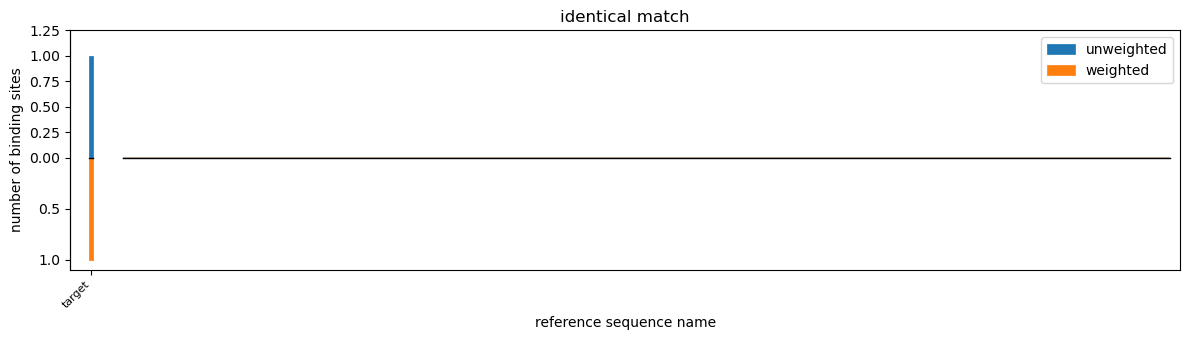

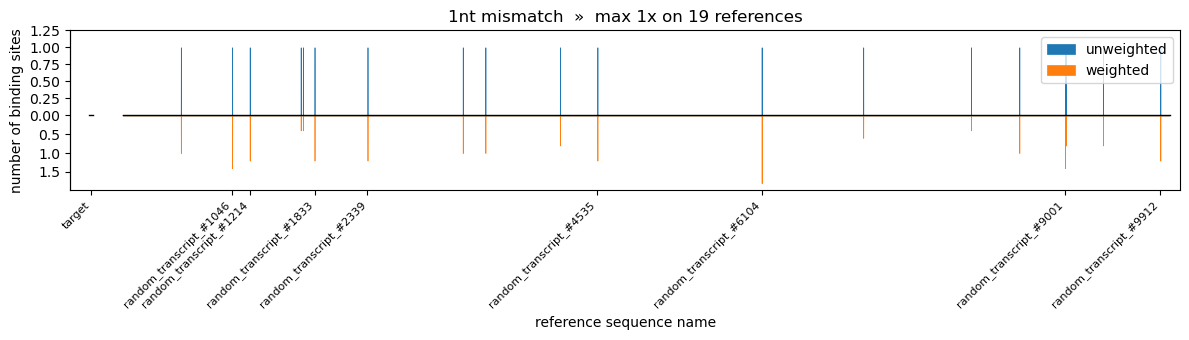

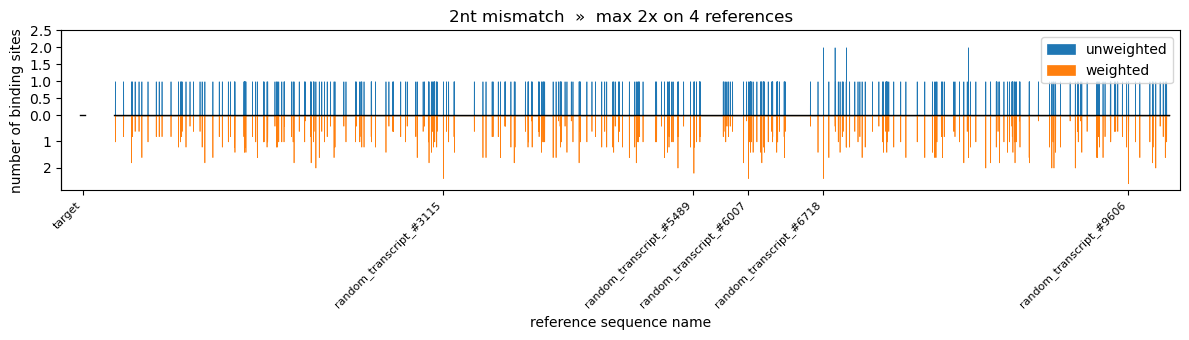

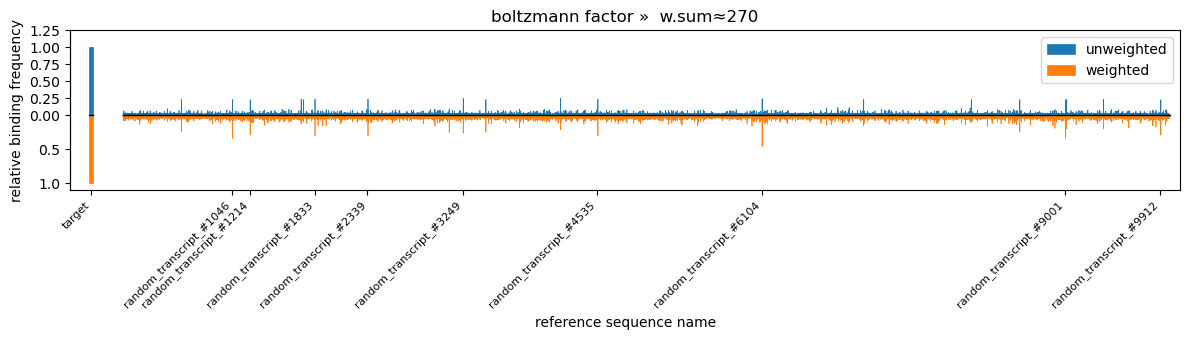

In [17]:
## Rank remaining sequences based on obtained metrics


select = filtered
select["rank max"] = 0
select["rank sum"] = 0
for col in [ '1nt mismatch W.sum','1nt mismatch W.max', '2nt mismatch W.sum', '2nt mismatch W.max', 'boltzmann factor W.sum r2t', 'boltzmann factor W.max r2t', ]:
    select["rank max"] = np.max([select[col].rank(pct = True), select["rank max"]], axis = 0)
    select["rank sum"] += select[col].rank(pct = True)
candidates = pd.concat([select.sort_values("rank max")[:15], select.sort_values("rank sum")[:15]]).sort_values("boltzmann factor W.max r2t")
candidates = candidates[~candidates.index.duplicated(keep='first')]

_df = candidates.drop(["SEQUENCE","SEQ_NAME"]+list(candidates.filter(like = "VIR").columns), axis = 1) # only use numerical columns
mat = np.array(_df.values)
mat -= mat.mean(axis = 0)
mat /= (mat.std(axis = 0)+1e-9)
mat += 2*(mat.std(axis = 0)+1e-9)

fig = plt.figure(figsize = (8, 12))
plt.matshow(mat.T, fignum = 0)

for (i, j), z in np.ndenumerate(np.array(_df.values)):
    plt.text(i,j, '{:0.4g}'.format(z), ha='center', va='center', rotation = 20, fontsize = 10)

plt.yticks(np.arange(0, mat.shape[1]), labels = _df.columns);
plt.xticks(np.arange(0, mat.shape[0]), labels = _df.index);
plt.show()

for i, row in candidates.iterrows():
    print("\n" + "-"*100)
    print(row)
    query_eval(row.SEQUENCE, reference_dataset, plot = True)
    plt.show()